<style>
  .glass-box {
    background: linear-gradient(145deg, rgba(255, 255, 255, 0.1), rgba(255, 255, 255, 0.2)), #2c3e50;
    padding: 20px; border-radius: 10px; text-align: center; max-width: 1200px; margin: 0 auto; display: flex;
    flex-direction: column; justify-content: center; height: 100px;
    transition: background-color 0.3s ease-in-out, color 0.3s ease-in-out;
  }
  .glass-box:hover {
    background: linear-gradient(145deg, #3498db, #e74c3c); color: #fff;
  }
  .glass-box h1 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 36px; margin: 0; transition: color 0.3s ease-in-out;
  }
</style>
<div class="glass-box"><h1>🛳️ <strong>Titanic Explorer: </strong>A Data-driven Quest for Survival Insights 🌊</h1></div>

In [1]:
# Libraries
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from tabulate import tabulate
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Ignore warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the training dataset
train_filepath = '/kaggle/input/titanic/train.csv'
train = pd.read_csv(train_filepath)

# Load the testing dataset
test_filepath = '/kaggle/input/titanic/test.csv'
test = pd.read_csv(test_filepath)

# Concatenate the training and testing datasets to fill missing values and extract common features
all_data = pd.concat([train, test], sort=True).reset_index(drop=True)

<style>
  .custom-box {
    background: linear-gradient(145deg, #3498db, #1abc9c); 
    padding: 15px; border-radius: 8px; margin: 20px; max-width: 350px;text-align: center;
    height: 70px; display: flex; flex-direction: column;
    justify-content: center; align-items: center;transition: background-color 0.3s ease-in-out;
  }
  .custom-box:hover {
    background: linear-gradient(145deg, #2ecc71, #3498db);
  }
  .custom-box h2 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 32px; margin: -5px 0 0 0;
  }
</style>
<div class="custom-box">
    <h2>
        📈 <strong>Data structure</strong> 📊
    </h2>
</div>

#### Column info
* `Pclass` = Ticket class
* `SibSp` = Siblings/Spouse count
* `Parch` = Parent/Child count
* `Embarked` = **'C'** *Cherbourg* **'Q'** = *Queenstown* **'S'** = *Southampton*

In [3]:
# View the overall data and data analysis
display(all_data)
display(all_data.describe(include="all"))

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [4]:
# Ploting the columns in the overall dataset
columns_to_plot = [col for col in all_data.columns if col not in ['PassengerId', 'Name']]
fig = make_subplots(rows=2, cols=5, subplot_titles=columns_to_plot)

for i, column in enumerate(columns_to_plot, start=1):
    row = (i - 1) // 5 + 1
    col = (i - 1) % 5 + 1
    
    trace = go.Histogram(x=all_data[column], name=column)
    fig.add_trace(trace, row=row, col=col)

fig.update_layout(
    title_text="Histograms for The Columns",
    title_x=0.5, 
    showlegend=False,  
    height=700, 
    width=1400  
)
pyo.iplot(fig)

<style>
  .custom-box {
    background: linear-gradient(145deg, #3498db, #1abc9c); 
    padding: 15px; border-radius: 8px; margin: 20px; max-width: 350px;text-align: center;
    height: 70px; display: flex; flex-direction: column;
    justify-content: center; align-items: center;transition: background-color 0.3s ease-in-out;
  }
  .custom-box:hover {
    background: linear-gradient(145deg, #2ecc71, #3498db);
  }
  .custom-box h2 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 32px; margin: -5px 0 0 0;
  }
</style>
<div class="custom-box">
    <h2>
        ⌛ <strong>Missing values</strong> 🧮
    </h2>
</div>

In [5]:
# There are a lot of missing values
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

<Axes: >

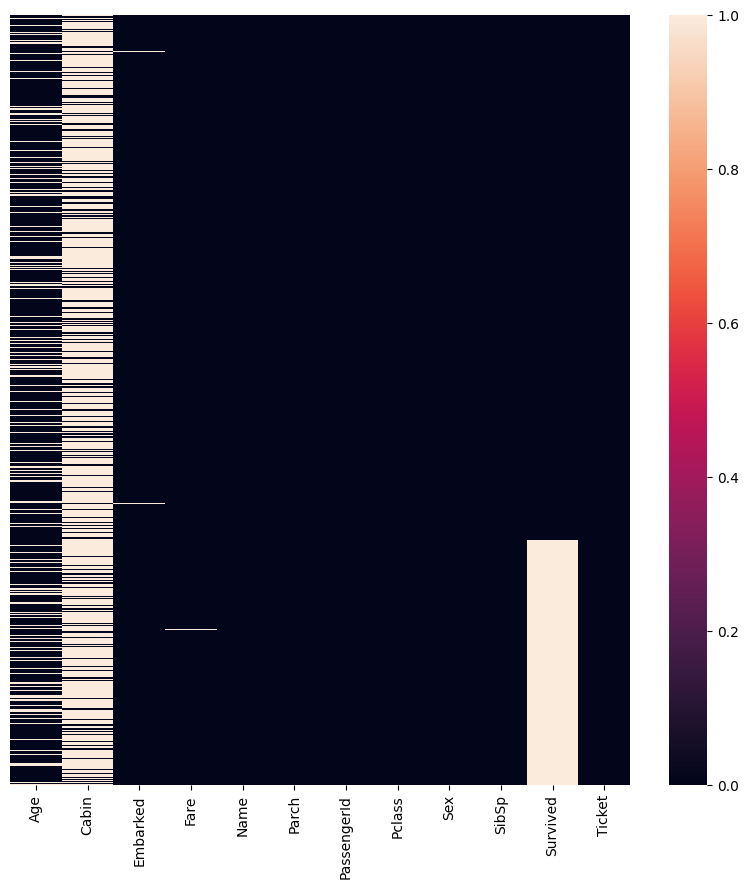

In [6]:
# Visualize the missing values
plt.figure(figsize=(10,10))
sns.heatmap(all_data.isnull(),yticklabels=False,cbar=True)

---

#### Missing `Age` values

To Fill the missing value of Age we can use different methods:
- Fill with the mean value of the highest correlation with age (Pclass) and sex
- Fill with the mean value of each title in the name and Pclass
- Use random sampling with no bais

In [7]:
# Finding the coorelation coefficients for age
numeric_columns = all_data.select_dtypes(include=[np.number]).columns
all_data_numeric = all_data[numeric_columns]

all_data_corr = all_data_numeric.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
all_data_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

age_corr = all_data_corr[all_data_corr['Feature 1'] == 'Age']
print(tabulate(age_corr[['Feature 1', 'Feature 2', 'Correlation Coefficient']], headers='keys', tablefmt='pretty', showindex=False))

+-----------+-------------+-------------------------+
| Feature 1 |  Feature 2  | Correlation Coefficient |
+-----------+-------------+-------------------------+
|    Age    |     Age     |           1.0           |
|    Age    |   Pclass    |   0.40810623423644377   |
|    Age    |    SibSp    |   0.24369899766477315   |
|    Age    |    Fare     |   0.1787398559996412    |
|    Age    |    Parch    |   0.1509170903635447    |
|    Age    |  Survived   |   0.07722109457217759   |
|    Age    | PassengerId |   0.02881445042111905   |
+-----------+-------------+-------------------------+


In [8]:
# Handling missing values for age
# 1. Filling the value of missing ages with median age of each Sex in each Pclass
# 2. Fill the missing values with mean age based on title (Name)

##### `By Sex and Pclass`

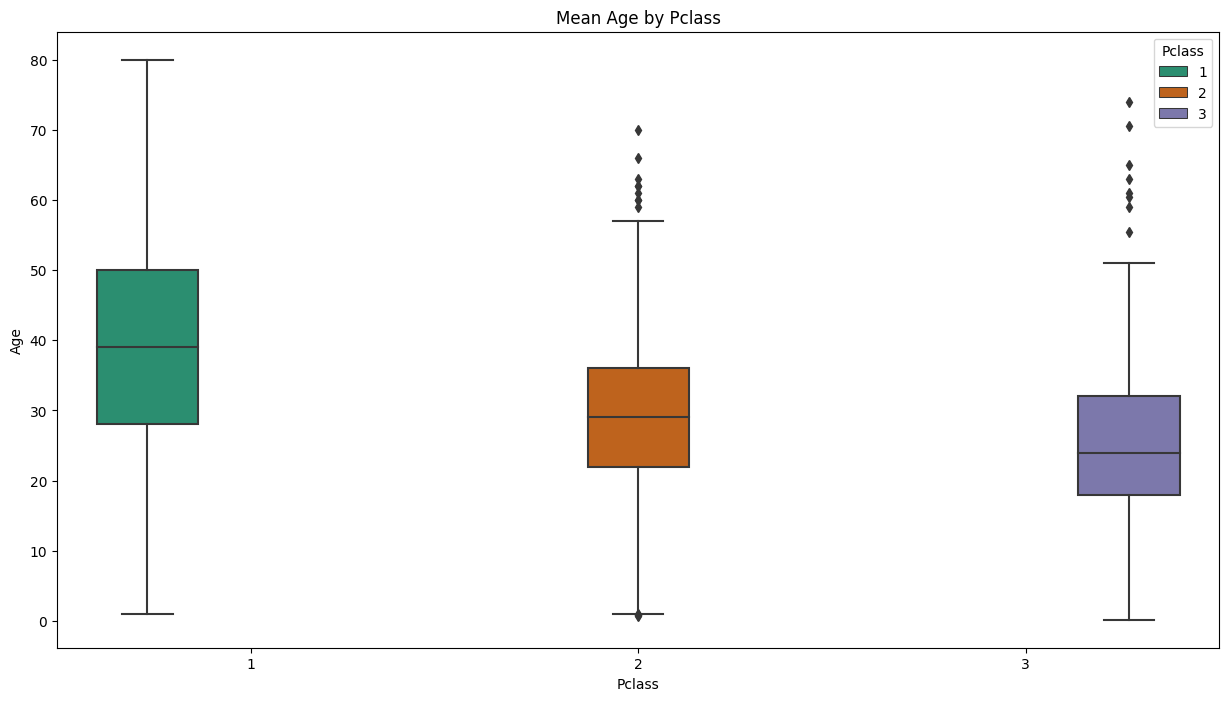

In [9]:
# Mean age of each Pclass in all the data set
fig, axes = plt.subplots(figsize=(15, 8))

sns.boxplot(x='Pclass', y='Age', hue='Pclass', data=all_data, palette='Dark2', ax=axes)
axes.set_title('Mean Age by Pclass')
plt.show()

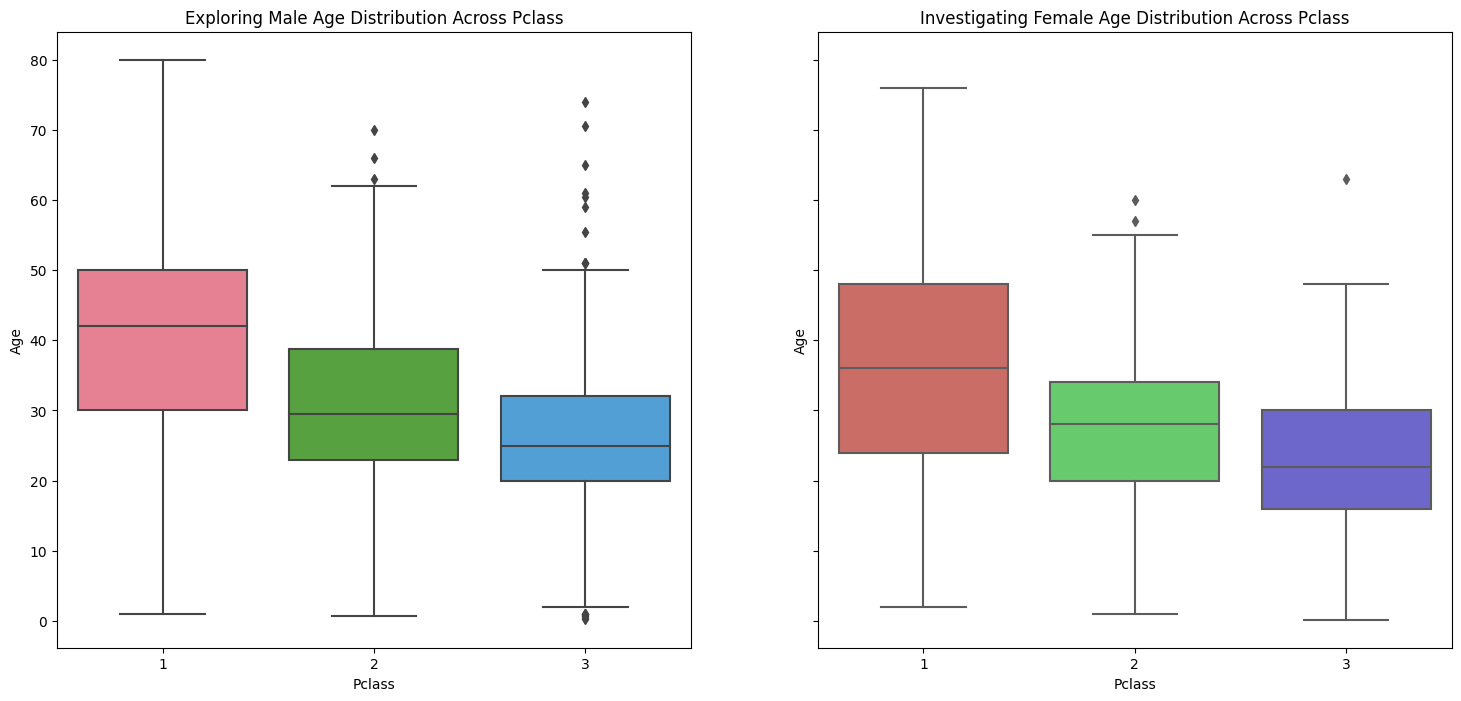

In [10]:
# instead of just using the median age Pclass we separate it based on sex
# Subplots with a different style
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Boxplot for Male passengers
sns.boxplot(x='Pclass', y='Age', data=all_data[all_data['Sex'] == 'male'], palette='husl', ax=axes[0])
axes[0].set_title('Exploring Male Age Distribution Across Pclass')

# Boxplot for Female passengers
sns.boxplot(x='Pclass', y='Age', data=all_data[all_data['Sex'] == 'female'], palette='hls', ax=axes[1])
axes[1].set_title('Investigating Female Age Distribution Across Pclass')

# Display the plots
plt.show()



In [11]:
# Filling missing age values with the median of each 'Sex' and 'Pclass' group
all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
non_numeric_age_before = all_data['Age'].loc[~pd.to_numeric(all_data['Age'], errors='coerce').notna()]
all_data['Age'] = pd.to_numeric(all_data['Age'], errors='coerce')
non_numeric_age_after = all_data['Age'].loc[~pd.to_numeric(all_data['Age'], errors='coerce').notna()]

print(f'Count of missing age values after conversion: {all_data["Age"].isnull().sum()}')


Count of missing age values after conversion: 0


##### `By Initial and Pclass`

In [12]:
# all_data['Initial'] = all_data['Name'].str.extract('([A-Za-z]+)\.')

# # Replace titles based on gender
# male_titles = ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']
# female_titles = ['Countess', 'Dona', 'Lady']
# miss_titles = ['Mlle', 'Ms', 'Mme']

# all_data['Initial'] = all_data['Initial'].replace(miss_titles, 'Miss')
# all_data['Initial'] = all_data['Initial'].replace(female_titles, 'Mrs')
# all_data['Initial'] = all_data['Initial'].replace(male_titles, 'Mr')

# # Handle 'Dr' titles separately for gender
# male_dr_filter = (all_data['Initial'] == 'Dr') & (all_data['Sex'] == 'male')
# female_dr_filter = (all_data['Initial'] == 'Dr') & (all_data['Sex'] == 'female')
# all_data.loc[male_dr_filter, 'Initial'] = 'Mr'
# all_data.loc[female_dr_filter, 'Initial'] = 'Mrs'

# display(all_data.groupby('Initial')['Age'].mean())
# display(all_data['Initial'].value_counts())
# display(all_data[['Age', 'Initial', 'Pclass']].head())
# all_data[all_data['Age'].isnull()].groupby('Initial')['Age'].count()


In [13]:
# fig, axes = plt.subplots(figsize=(15, 8))

# sns.boxplot(x='Initial', y='Age', hue='Initial', data=all_data, palette='Dark2', ax=axes)
# axes.set_title('Mean Age by Pclass')
# plt.show()

In [14]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# sns.boxplot(x='Pclass', y='Age', hue='Pclass', data=all_data[all_data['Initial'] == 'Mr'], palette='Dark2', ax=axes[0, 0])
# axes[0, 0].set_title('Mr - Median Age by Pclass')

# sns.boxplot(x='Pclass', y='Age', hue='Pclass', data=all_data[all_data['Initial'] == 'Miss'], palette='Dark2', ax=axes[0, 1])
# axes[0, 1].set_title('Miss - Median Age by Pclass')

# sns.boxplot(x='Pclass', y='Age', hue='Pclass', data=all_data[all_data['Initial'] == 'Mrs'], palette='Dark2', ax=axes[1, 0])
# axes[1, 0].set_title('Mrs - Median Age by Pclass')

# sns.boxplot(x='Pclass', y='Age', hue='Pclass', data=all_data[all_data['Initial'] == 'Master'], palette='Dark2', ax=axes[1, 1])
# axes[1, 1].set_title('Master - Median Age by Pclass')

# plt.tight_layout()  
# plt.show()

In [15]:
# # Filling the missing age values
# mean_age_by_initial_pclass = all_data.groupby(['Initial', 'Pclass'])['Age'].mean()

# # Define a function to fill missing ages based on the mean age for each 'Initial' within each 'Pclass'
# def fill_age(row):
#     if pd.isnull(row['Age']):
#         return mean_age_by_initial_pclass.loc[row['Initial'], row['Pclass']]
#     else:
#         return row['Age']

# # Apply the function to fill missing values in the 'Age' column
# all_data['Age'] = all_data.apply(fill_age, axis=1)

# # Display the DataFrame with filled missing values
# print(all_data[['Initial', 'Pclass', 'Age']].head())
# all_data['Age'].isnull().sum()
# all_data.drop(['Initial'], axis=1, inplace=True)


---

#### Missing `Cabin` values
- There are a lot of missing Cabin values
- It seems the starting letter of the Cabin determines the passengers location on the Titanic

In [16]:
#Handling missing values for Cabin
# 1. Giving a new cabin for missing values

In [17]:
# Replacing Cabin with starting letters
print(f"Out of {len(all_data['Cabin'])} passengers {all_data['Cabin'].isnull().sum()} have missing Cabin values")
all_data['Cabin'] =all_data['Cabin'].str.extract(r'^([A-Z])', expand=False)
all_data['Cabin'].dropna(inplace=True)
all_data['Cabin'].value_counts()

Out of 1309 passengers 1014 have missing Cabin values


Cabin
C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: count, dtype: int64

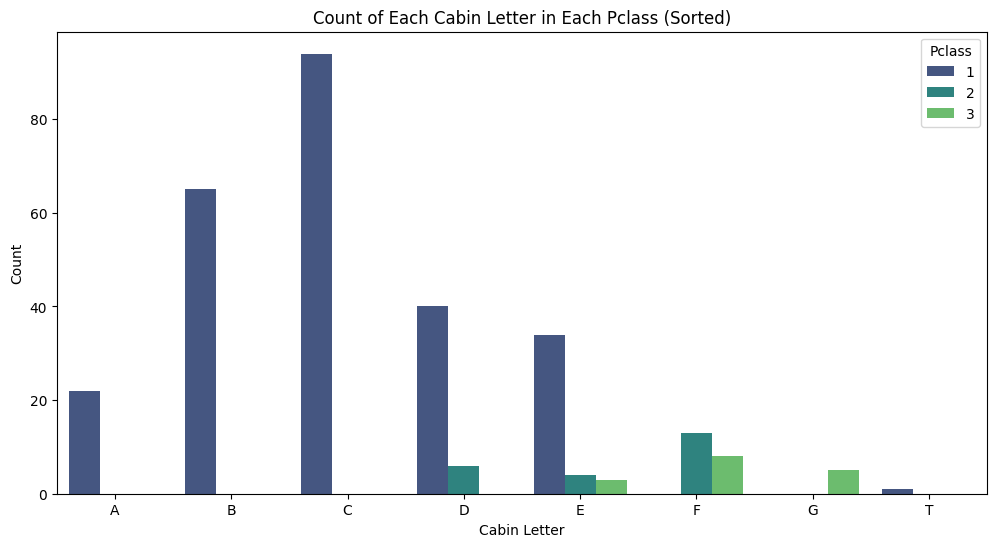

In [18]:
# Sorting unique cabin letters
sorted_cabins = sorted(all_data['Cabin'].dropna().unique())

# Plotting cabin vs Pclass
plt.figure(figsize=(12, 6))
sns.countplot(x='Cabin', hue='Pclass', data=all_data, order=sorted_cabins, palette='viridis')
plt.title('Count of Each Cabin Letter in Each Pclass (Sorted)')
plt.xlabel('Cabin Letter')
plt.ylabel('Count')
plt.show()


In [19]:
# # Plotting missing cabin values by Pclass
# plt.figure(figsize=(10, 6))
# sns.countplot(x='Pclass', hue=all_data['Cabin'].isnull(), data=all_data, palette='viridis')  
# plt.title('Distribution of Missing Cabin Values Across Pclass') 
# plt.xlabel('Pclass')
# plt.ylabel('Count')
# plt.legend(title='Missing Cabin')
# plt.show()


> *We can see that the missing values have a low Survival rate which is crucial for our prediction,
so we can make the unknowns into one class rather than spreading them to other classes.*

In [20]:
# Filling NaN values with Unknown
all_data['Cabin'].fillna('Unknown', inplace=True)
cabin_counts = all_data.groupby('Cabin').size().reset_index(name='TotalMembers')

# Calculate the survival percentage for each cabin
survival_counts = all_data.groupby(['Cabin', 'Survived']).size().unstack(fill_value=0).reset_index()
merged_df = pd.merge(cabin_counts, survival_counts, on='Cabin')
merged_df['SurvivalPercentage'] = (merged_df[1] / merged_df['TotalMembers']) * 100
print(merged_df[['Cabin', 'SurvivalPercentage']])
print(f'Count of missing age values after conversion: {all_data["Cabin"].isnull().sum()}')


     Cabin  SurvivalPercentage
0        A           31.818182
1        B           53.846154
2        C           37.234043
3        D           54.347826
4        E           58.536585
5        F           38.095238
6        G           40.000000
7        T            0.000000
8  Unknown           20.315582
Count of missing age values after conversion: 0


---

#### Missing `Embarked` values

- There is only two missing Embarked values

In [21]:
# dispalyig the missing Embarked values
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


> *We can see that both missing values have the same Cabin and ticket number. Which might suggest they were togther.*

In [22]:
#Handling missing values for Embarked
# 1. Fill it with same mode value for both since they have same tickets

In [23]:
# Finding the mode base on each class
print('Mode of Embarked based on Pclass:')
print(all_data.groupby('Pclass')['Embarked'].apply(lambda x: x.mode().iloc[0]))

Mode of Embarked based on Pclass:
Pclass
1    S
2    S
3    S
Name: Embarked, dtype: object


          Count  Percentage
Embarked                   
S           914   69.931140
C           270   20.657995
Q           123    9.410865


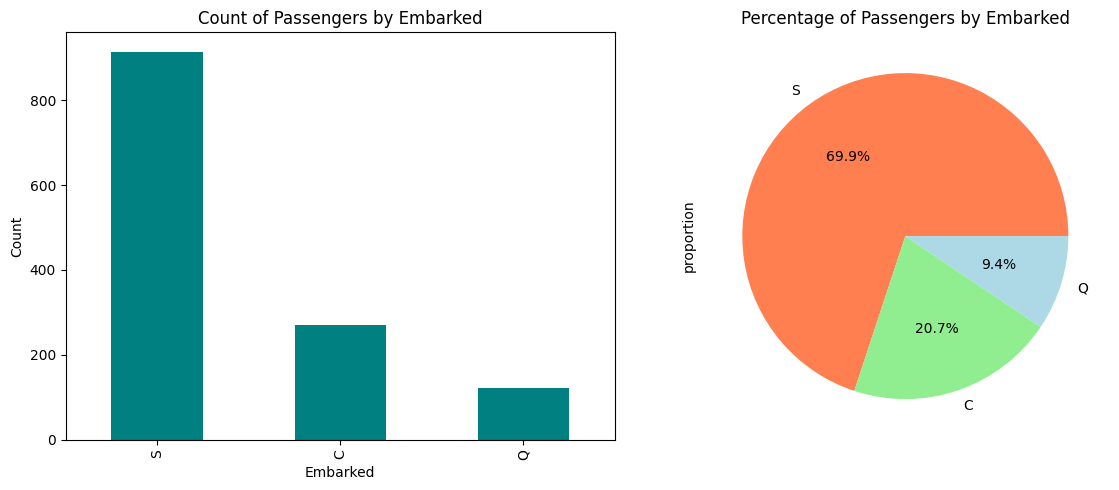

In [24]:
# Ploting the Embarked column
embarked_count = all_data['Embarked'].value_counts()
embarked_percentage = all_data['Embarked'].value_counts(normalize=True) * 100

embarked_stats = pd.DataFrame({'Count': embarked_count, 'Percentage': embarked_percentage})
print(embarked_stats)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Count plot with different color
all_data['Embarked'].value_counts().plot(kind='bar', ax=axes[0], color='teal') 
axes[0].set_title('Count of Passengers by Embarked')
axes[0].set_xlabel('Embarked')
axes[0].set_ylabel('Count')

# Pie chart for Percentage plot with different colors
embarked_percentage.plot(kind='pie', autopct='%1.1f%%', ax=axes[1], colors=['coral', 'lightgreen', 'lightblue']) 
axes[1].set_title('Percentage of Passengers by Embarked')

plt.tight_layout()
plt.show()

> *Since the mode for all the class is `S` we can fill the missing values with `S`*

In [25]:
# Filling the missing values in Embarked with S
all_data['Embarked'] = all_data['Embarked'].fillna('S')
print(f'Count of missing age values after conversion: {all_data["Embarked"].isnull().sum()}')

Count of missing age values after conversion: 0


---

#### Missing `Fare` values

- There is one missing Fare value in the test data

In [26]:
# Displaying the missing Fare value
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [27]:
# Fare mode based on Pclass 
all_data.groupby('Pclass')['Fare'].apply(lambda fare: fare.mode().iloc[0])

Pclass
1    26.55
2    13.00
3     8.05
Name: Fare, dtype: float64

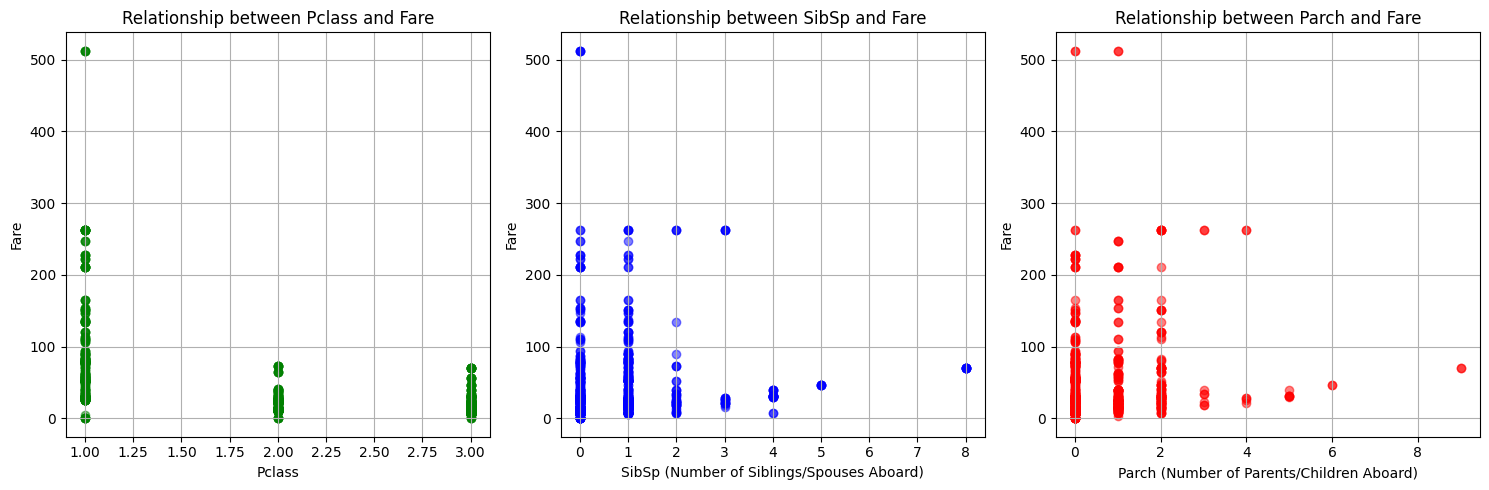

In [28]:
# Plot realtionship of Fare with Pclass, SibSp and Parch

# Plot for Pclass and Fare
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(all_data['Pclass'],all_data['Fare'], alpha=0.5, color='green')
plt.title('Relationship between Pclass and Fare')
plt.xlabel('Pclass')
plt.ylabel('Fare')
plt.grid(True)

# Plot for SibSp and Fare
plt.subplot(1, 3, 2)
plt.scatter(all_data['SibSp'],all_data['Fare'], alpha=0.5, color='blue')
plt.title('Relationship between SibSp and Fare')
plt.xlabel('SibSp (Number of Siblings/Spouses Aboard)')
plt.ylabel('Fare')
plt.grid(True)

# Plot for Parch and Fare
plt.subplot(1, 3, 3)
plt.scatter(all_data['Parch'], all_data['Fare'], alpha=0.5, color='red')
plt.title('Relationship between Parch and Fare')
plt.xlabel('Parch (Number of Parents/Children Aboard)')
plt.ylabel('Fare')
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
# Filling the missing fare with median fare based on Pclass and family
fare_median = all_data['Fare'].fillna(all_data.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0])
all_data['Fare'] = all_data['Fare'].fillna(fare_median)
print(f'Count of missing age values after conversion: {all_data["Fare"].isnull().sum()}')

Count of missing age values after conversion: 0


---

**`Done with Data cleaning`**

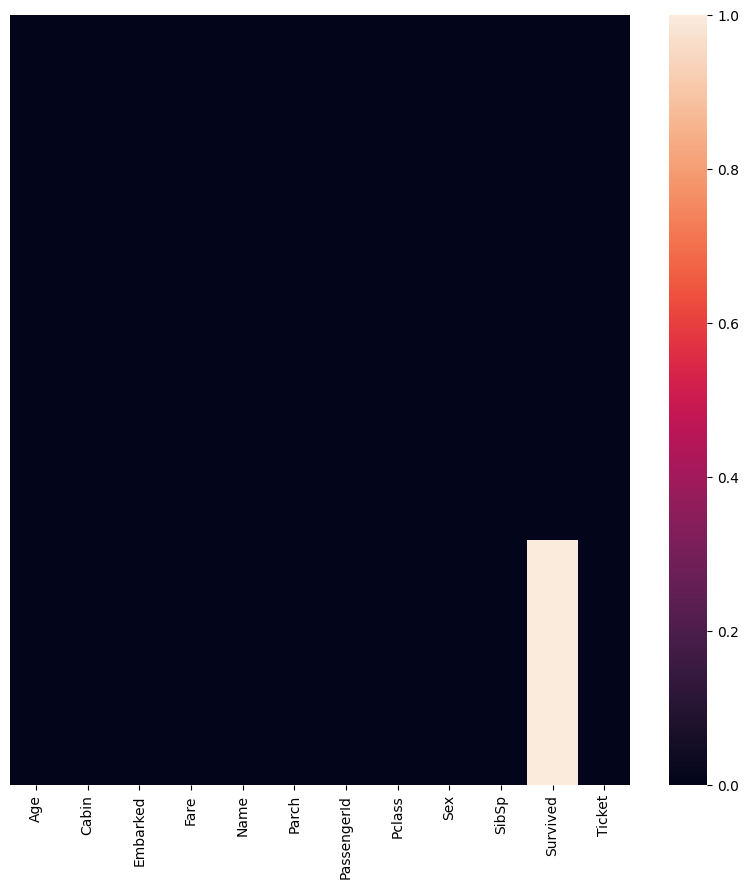

In [30]:
# Print the df after filling in missing values
plt.figure(figsize=(10,10))
sns.heatmap(all_data.isnull(), yticklabels=False, cbar=True)

# Split all_data back into train and test
train, test = all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

---

<style>
  .custom-box {
    background: linear-gradient(145deg, #3498db, #1abc9c); 
    padding: 15px; border-radius: 8px; margin: 20px; max-width: 450px;text-align: center;
    height: 70px; display: flex; flex-direction: column;
    justify-content: center; align-items: center;transition: background-color 0.3s ease-in-out;
  }
  .custom-box:hover {
    background: linear-gradient(145deg, #2ecc71, #3498db);
  }
  .custom-box h2 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 32px; margin: -5px 0 0 0;
  }
</style>
<div class="custom-box">
    <h2>
        🧩 <strong>Feature Enginneering</strong> ✍️
    </h2>
</div>

In [31]:
# Displaying all the columns
train.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')

In [32]:
# Plotting the columns after filling the missing values
columns_to_plot = [col for col in all_data.columns if col not in ['PassengerId', 'Name', 'Initial']]
fig = make_subplots(rows=2, cols=5, subplot_titles=columns_to_plot)

for i, column in enumerate(columns_to_plot, start=1):
    row = (i - 1) // 5 + 1
    col = (i - 1) % 5 + 1
    
    trace = go.Histogram(x=all_data[column], name=column)
    fig.add_trace(trace, row=row, col=col)

fig.update_layout(
    title_text="Histograms for Each Column",
    title_x=0.5, 
    showlegend=False,  
    height=700, 
    width=1400  
)
pyo.iplot(fig)

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">1. Survived</span>** 💀

> *This is the goal (label) we will try to predict for the test data.*

Total People Survived: 342.0
Total People Not Survived: 549.0
--------------------------------------------
Percentage of People Survived: 38.38
Percentage of People Not Survived: 61.62


Text(0.5, 1.0, 'Survived')

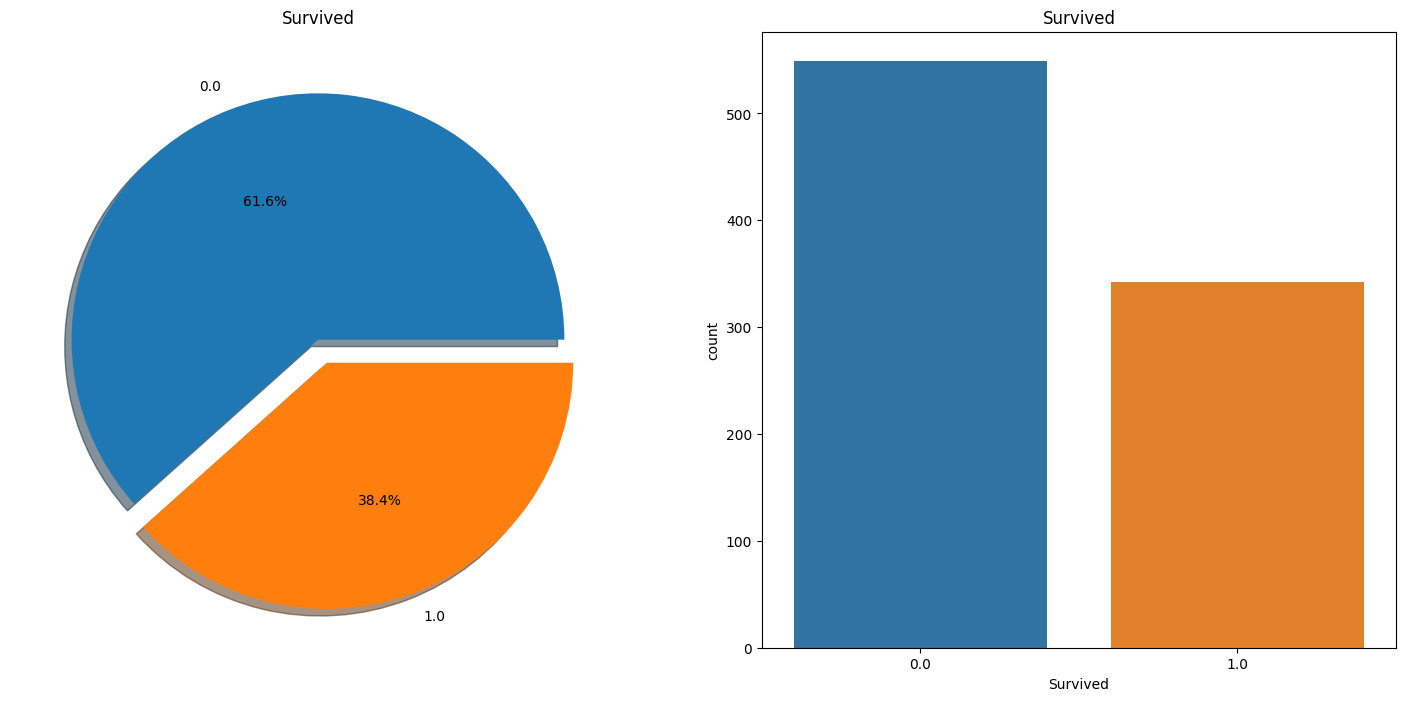

In [33]:
# Plot and show the Survived num and percentage
total_survived = train['Survived'].sum()
total_not_survived = train['Survived'].count() - total_survived
print("Total People Survived:", total_survived)
print("Total People Not Survived:", total_not_survived)

print("--------------------------------------------")
total_passengers = train.shape[0]
percentage_survived = (total_survived / total_passengers) * 100
percentage_not_survived = (total_not_survived / total_passengers) * 100
print("Percentage of People Survived:", round(percentage_survived, 2))
print("Percentage of People Not Survived:", round(percentage_not_survived, 2))

# Plotting 
f, ax = plt.subplots(1, 2, figsize=(18, 8))
# Pie chart
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

# Count plot
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')

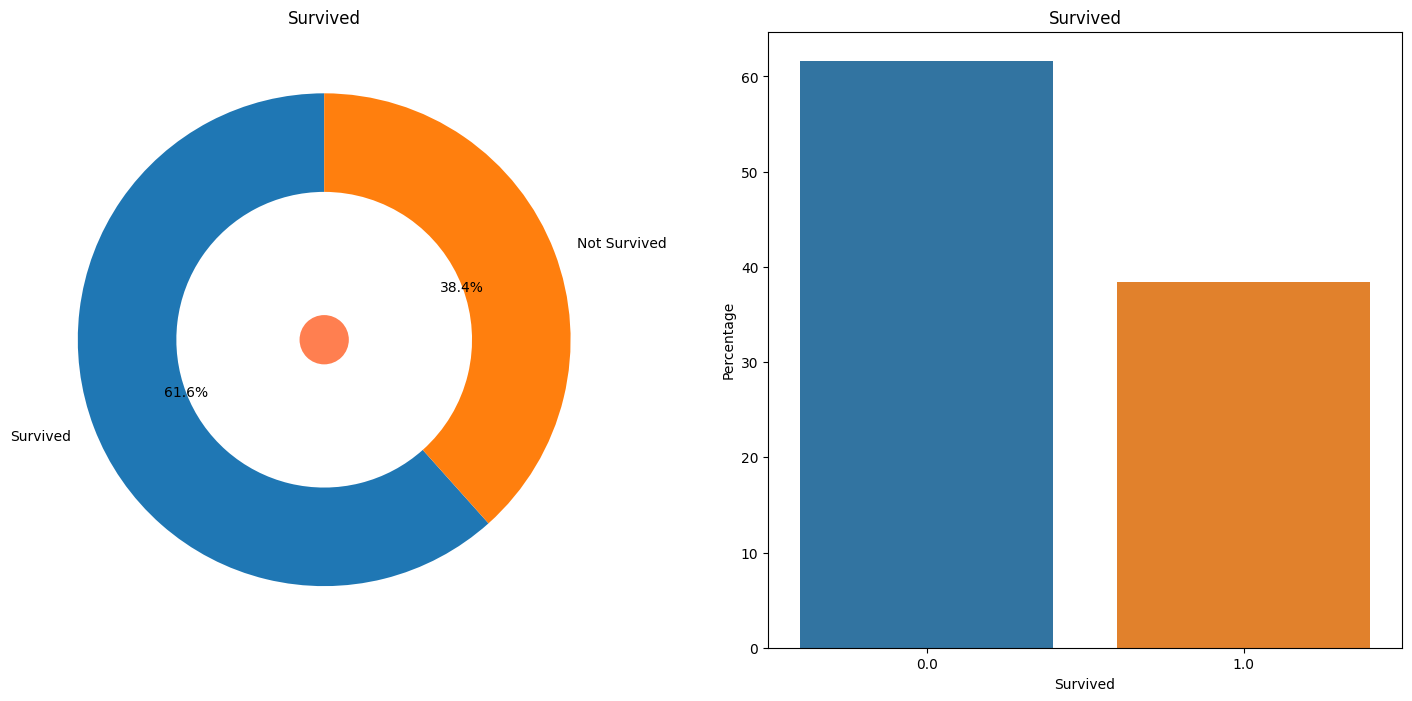

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Donut chart
ax[0].pie(train['Survived'].value_counts(), labels=['Survived', 'Not Survived'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
ax[0].add_artist(plt.Circle((0,0),0.1,fc='coral'))
ax[0].set_title('Survived')

# Percentage bar plot
sns.barplot(x=train['Survived'].value_counts().index, y=train['Survived'].value_counts(normalize=True) * 100, ax=ax[1])
ax[1].set_title('Survived')
ax[1].set_ylabel('Percentage')

plt.show()


### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">2. Sex</span>** 🚹🚺

> *Although it's crucial to determine the survival of passengers, it doesn't offer other features we can extrct from it.*

In [35]:
# Tabular dispaly of Sex effect on the survival of passengers
print("Males count:", len(train[train['Sex'] == 'male']))
print("Females count:", len(train[train['Sex'] == 'female']))

print("Survival Statistics by Sex:")
survival_stats = train.groupby(['Sex', 'Survived']).size().unstack()
print(tabulate(survival_stats, headers=['Not Survived', 'Survived'], tablefmt="grid"))

print("Survival Percentages by Sex:")
total_passengers = len(train)
survival_percentages = (survival_stats / total_passengers) * 100
print(tabulate(survival_percentages, headers=['Not Survived', 'Survived'], tablefmt="grid", floatfmt=".2f"))

total_males = train[train['Sex'] == 'male'].shape[0]
total_females = train[train['Sex'] == 'female'].shape[0]

male_survival_percentage = round((survival_stats.loc['male', 1] / total_males) * 100, 2)
male_not_survival_percentage = round((survival_stats.loc['male', 0] / total_males) * 100, 2)
female_survival_percentage = round((survival_stats.loc['female', 1] / total_females) * 100, 2)
female_not_survival_percentage = round((survival_stats.loc['female', 0] / total_females) * 100, 2)

table_data = [
    ["Male Survival Percentage", male_survival_percentage],
    ["Male Not Survival Percentage", male_not_survival_percentage],
    ["Female Survival Percentage", female_survival_percentage],
    ["Female Not Survival Percentage", female_not_survival_percentage]
]

headers = ["Category", "Percentage"]

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))


Males count: 577
Females count: 314
Survival Statistics by Sex:
+--------+----------------+------------+
|        |   Not Survived |   Survived |
+========+================+============+
| female |             81 |        233 |
+--------+----------------+------------+
| male   |            468 |        109 |
+--------+----------------+------------+
Survival Percentages by Sex:
+--------+----------------+------------+
|        |   Not Survived |   Survived |
+========+================+============+
| female |           9.09 |      26.15 |
+--------+----------------+------------+
| male   |          52.53 |      12.23 |
+--------+----------------+------------+
+--------------------------------+--------------+
| Category                       |   Percentage |
+================================+==============+
| Male Survival Percentage       |        18.89 |
+--------------------------------+--------------+
| Male Not Survival Percentage   |        81.11 |
+--------------------------------

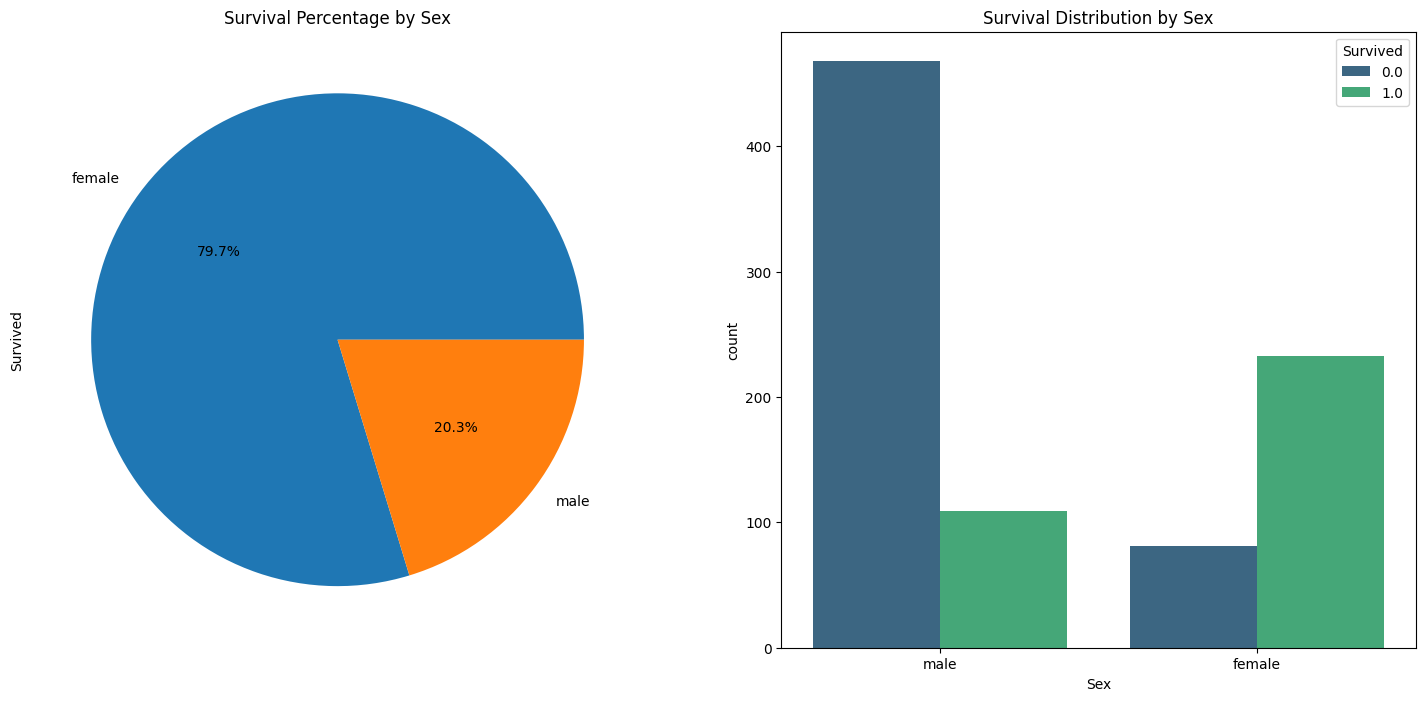

In [36]:
# Plotting the survival percentage of each gender
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Pie chart for survival percentage by sex
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.pie(y='Survived', autopct='%1.1f%%', ax=ax[0], legend=False)
ax[0].set_title('Survival Percentage by Sex')

# Stacked bar plot for survival distribution by sex
sns.countplot(x='Sex', hue='Survived', data=train, ax=ax[1], palette='viridis')  # You can change 'viridis' to any other seaborn color palette
ax[1].set_title('Survival Distribution by Sex')

plt.show()

In [37]:
# create categorical variable
# all_data['Sex'].replace(['male','female'],[0,1],inplace=True)

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">3. Pclass</span>** 👨‍✈️👨‍💼👩‍🔧

In [38]:
# Shows Pclass relationship with survival
unique_pclass_values = sorted(train['Pclass'].unique())
total_passengers = len(train)

table_data = []

for pclass in unique_pclass_values:
    count = len(train[train['Pclass'] == pclass])
    percentage = (count / total_passengers) * 100
    survived_count = len(train[(train['Pclass'] == pclass) & (train['Survived'] == 1)])
    not_survived_count = len(train[(train['Pclass'] == pclass) & (train['Survived'] == 0)])

    row_data = [f"Class {pclass}", count, f"{percentage:.2f}%",
                survived_count, f"{(survived_count / count) * 100:.2f}%",
                not_survived_count, f"{(not_survived_count / count) * 100:.2f}%"]

    table_data.append(row_data)

headers = ["Class", "Total Count", "Percentage", "Survived Count", "Survived Percentage", "Not Survived Count", "Not Survived Percentage"]

print(tabulate(table_data, headers=headers, tablefmt="grid"))
pd.crosstab(train.Pclass,train.Survived,margins=True).style.background_gradient(cmap='plasma')

+---------+---------------+--------------+------------------+-----------------------+----------------------+---------------------------+
| Class   |   Total Count | Percentage   |   Survived Count | Survived Percentage   |   Not Survived Count | Not Survived Percentage   |
+=========+===============+==============+==================+=======================+======================+===========================+
| Class 1 |           216 | 24.24%       |              136 | 62.96%                |                   80 | 37.04%                    |
+---------+---------------+--------------+------------------+-----------------------+----------------------+---------------------------+
| Class 2 |           184 | 20.65%       |               87 | 47.28%                |                   97 | 52.72%                    |
+---------+---------------+--------------+------------------+-----------------------+----------------------+---------------------------+
| Class 3 |           491 | 55.11%       

Survived,0.000000,1.000000,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


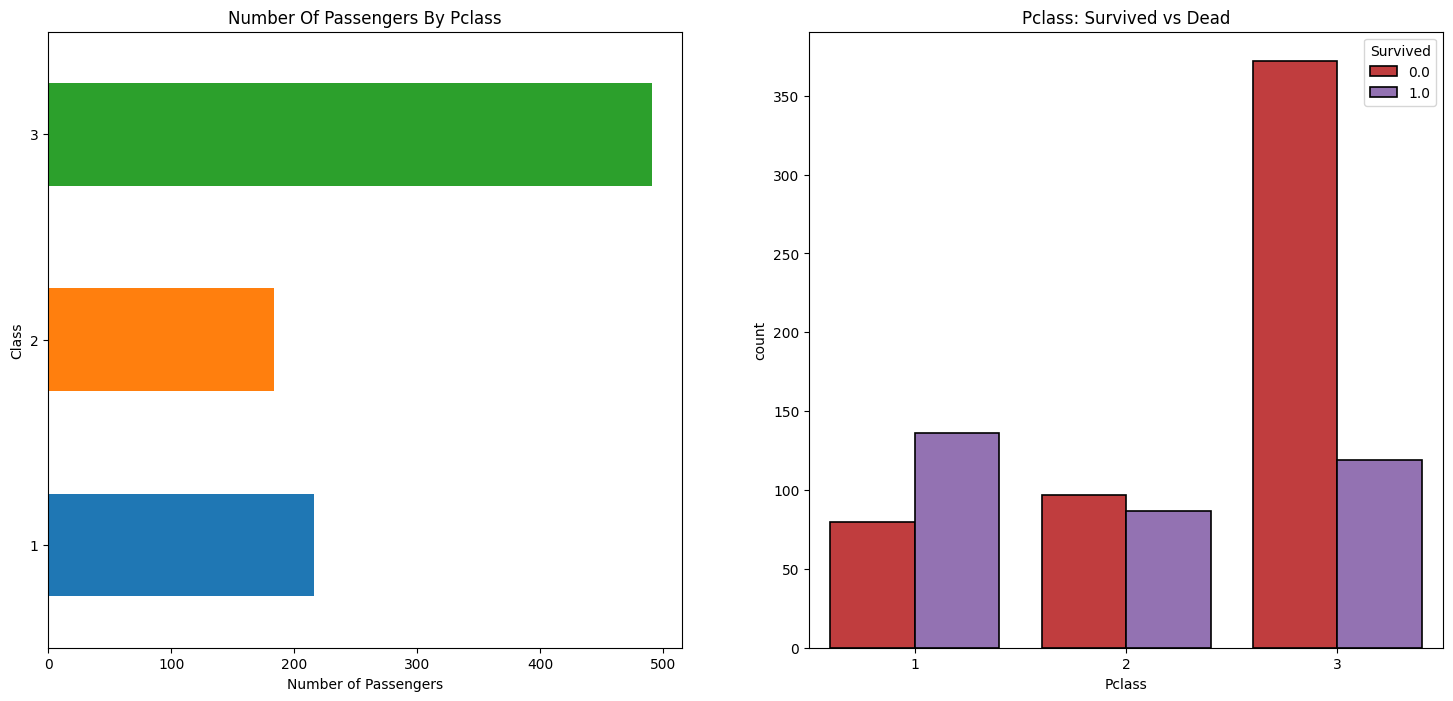

In [39]:
# Plotting Pclass relationship with Survival
f, ax = plt.subplots(1, 2, figsize=(18, 8))
# Bar chart 
train['Pclass'].value_counts().sort_index().plot.barh(color=['#1f77b4', '#ff7f0e', '#2ca02c'], ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Class')
ax[0].set_xlabel('Number of Passengers')

# Count plot 
sns.countplot(x='Pclass', hue='Survived', data=train, ax=ax[1], palette=['#d62728', '#9467bd'], edgecolor='black', linewidth=1.2)
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

In [40]:
# Relation between Passenger Pclass and Sex
fig = px.parallel_categories(train, dimensions=["Pclass", "Sex"], labels={"Pclass": "Passenger Class", "Sex": "Sex"})
fig.update_traces(line=dict(color="green")) 
fig.update_layout(
    title="Relation between Passenger Class and Sex",
    showlegend=True,
    width=600 
)

fig.show()


In [41]:
# Create dummies
# all_data['Pclass'].replace(['1','2','3'],[0,1,2],inplace=True)

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">4. Cabin</span>** 🚢

In [42]:
# cabin value count
all_data.Cabin.value_counts()

Cabin
Unknown    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: count, dtype: int64

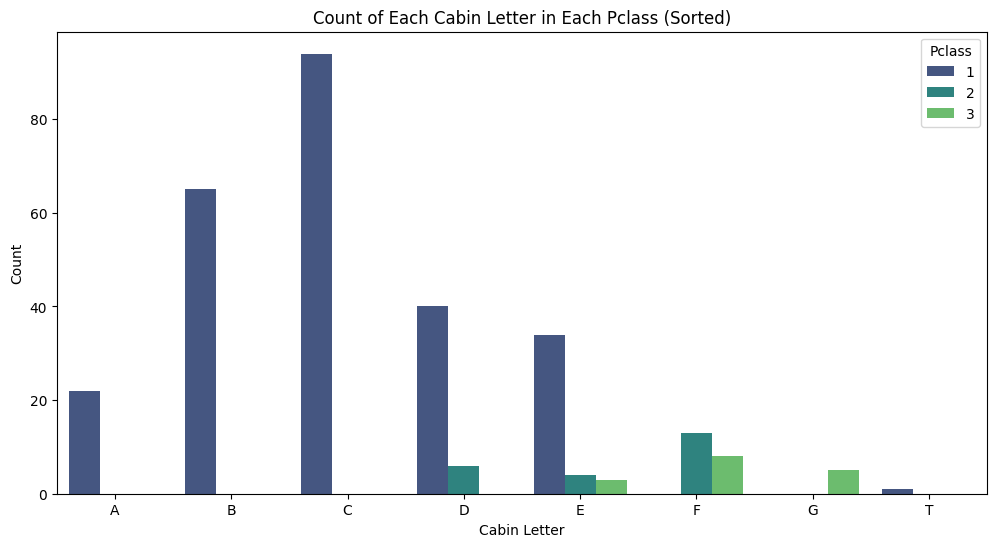

In [43]:
# Plotting cabin vs Pclass
plt.figure(figsize=(12, 6))
sns.countplot(x='Cabin', hue='Pclass', data=all_data, order=sorted_cabins, palette='viridis')
plt.title('Count of Each Cabin Letter in Each Pclass (Sorted)')
plt.xlabel('Cabin Letter')
plt.ylabel('Count')
plt.show()


**From the Figure:**
- Cabin A, B, C and T are only Pclass 1
- Cabin D and E are for all Pclasses with Pclass 1 majority
- Cabin F and G are for all Pclass 2 and 3

> *We can conclude that as it goes from A to low letters it is more occupied by Pclass 3*

In [44]:
# Merging Cabin with same Pclass in the same group
all_data['Cabin'] = all_data['Cabin'].replace(['A', 'B', 'C', 'T'], 'ABCT')
all_data['Cabin'] = all_data['Cabin'].replace(['D', 'E'], 'DE')
all_data['Cabin'] = all_data['Cabin'].replace(['F', 'G'], 'FG')
all_data['Cabin'] = all_data['Cabin'].replace(['Unknown'], 'None')

all_data['Cabin'].value_counts()


Cabin
None    1014
ABCT     182
DE        87
FG        26
Name: count, dtype: int64

In [45]:
# all_data['Cabin'].replace(['ABCT','DE','FG','None'],[0,1,2,3],inplace=True)

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">5. Embarked</span>** 🗺️

In [46]:
display(pd.crosstab(train.Embarked, train.Survived,margins=True).style.background_gradient(cmap='plasma'))
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Survived,0.000000,1.000000,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,219,646
All,549,342,891


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


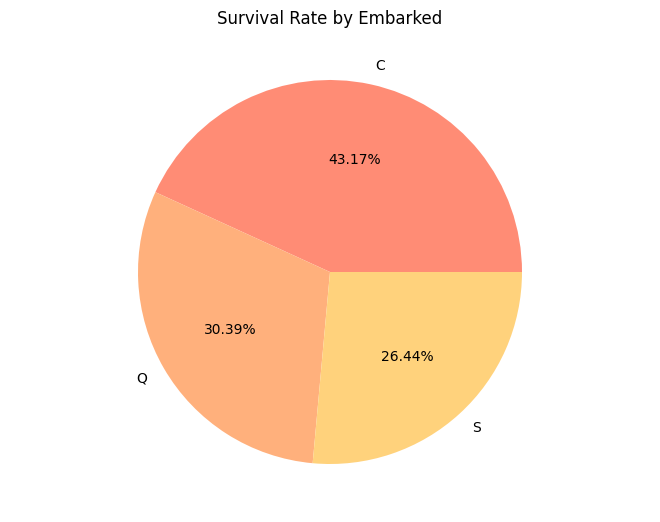

In [47]:
# Calculating survival rates by Embarked
embarked_survival_rates = train.groupby(['Embarked'], as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

# Plotting the pie chart using calculated survival rates with different coral-like colors
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')

labels = embarked_survival_rates['Embarked'].values
sizes = embarked_survival_rates['Survived'].values

# Different coral-like color palette
colors = ['#FF8C75', '#FFB07C', '#FFD27C']

ax.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors)

plt.title('Survival Rate by Embarked')
plt.show()


In [48]:
# all_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">6. Name</span>** 📑

In [49]:
# Title extraction and visualization
df = all_data.copy()
df['Name'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
display(df['Name'].value_counts())
display(pd.crosstab(df.Name,df.Sex).T.style.background_gradient(cmap='plasma') )
del df

Name
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

Name,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


Different way of Bining

In [50]:
# # Map the titles in to 4 groups
# title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
#                  "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
#                  "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
# all_data['Name'] = all_data["Name"].map(title_mapping)

Another

In [51]:
# # Instead of others, lets put it by gender
# male_titles = ['Capt', 'Col', 'Don','Jonkheer','Major','Rev','Sir'] # all classified as male
# female_titles = ['Countess','Dona','Lady'] # all as female
# miss_titles = ['Mlle','Ms','Mme']

# for df in all_data:
#     df['Name'] = df['Name'].replace(miss_titles, 'Miss')
#     df['Name'] = df['Name'].replace(female_titles, 'Mrs')
#     df['Name'] = df['Name'].replace(male_titles, 'Mr')
#     male_dr_filter = (df.Title == 'Dr') & (df.Sex == 'male')
#     female_dr_filter = (df.Title == 'Dr') & (df.Sex == 'female')
#     df.loc[male_dr_filter, ['Name']] = 'Mr'
#     df.loc[female_dr_filter, ['Name']] = 'Mrs'

In [52]:
# all_data['Initial'].replace(['Miss','Mrs','Mr','Master'],[0,1,2,3],inplace=True)
# # Drop Name column
# all_data.drop(['Name'], axis=1, inplace=True)
# all_data

Extracting Title, Marital_Status and surename features from name

In [53]:
# Extracting 'Title' from 'Name'
all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# Creating 'Marital_Status' based on 'Title'
all_data['Marital_Status'] = 0
all_data.loc[all_data['Title'] == 'Mrs', 'Marital_Status'] = 1

# Displaying relevant columns
columns_to_display = ['Name', 'Title', 'Marital_Status']
displayed_data = all_data[columns_to_display]

# Showing the result
displayed_data.head()


,Name,Title,Marital_Status
0,"Braund, Mr. Owen Harris",Mr,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,1
2,"Heikkinen, Miss. Laina",Miss,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,1
4,"Allen, Mr. William Henry",Mr,0


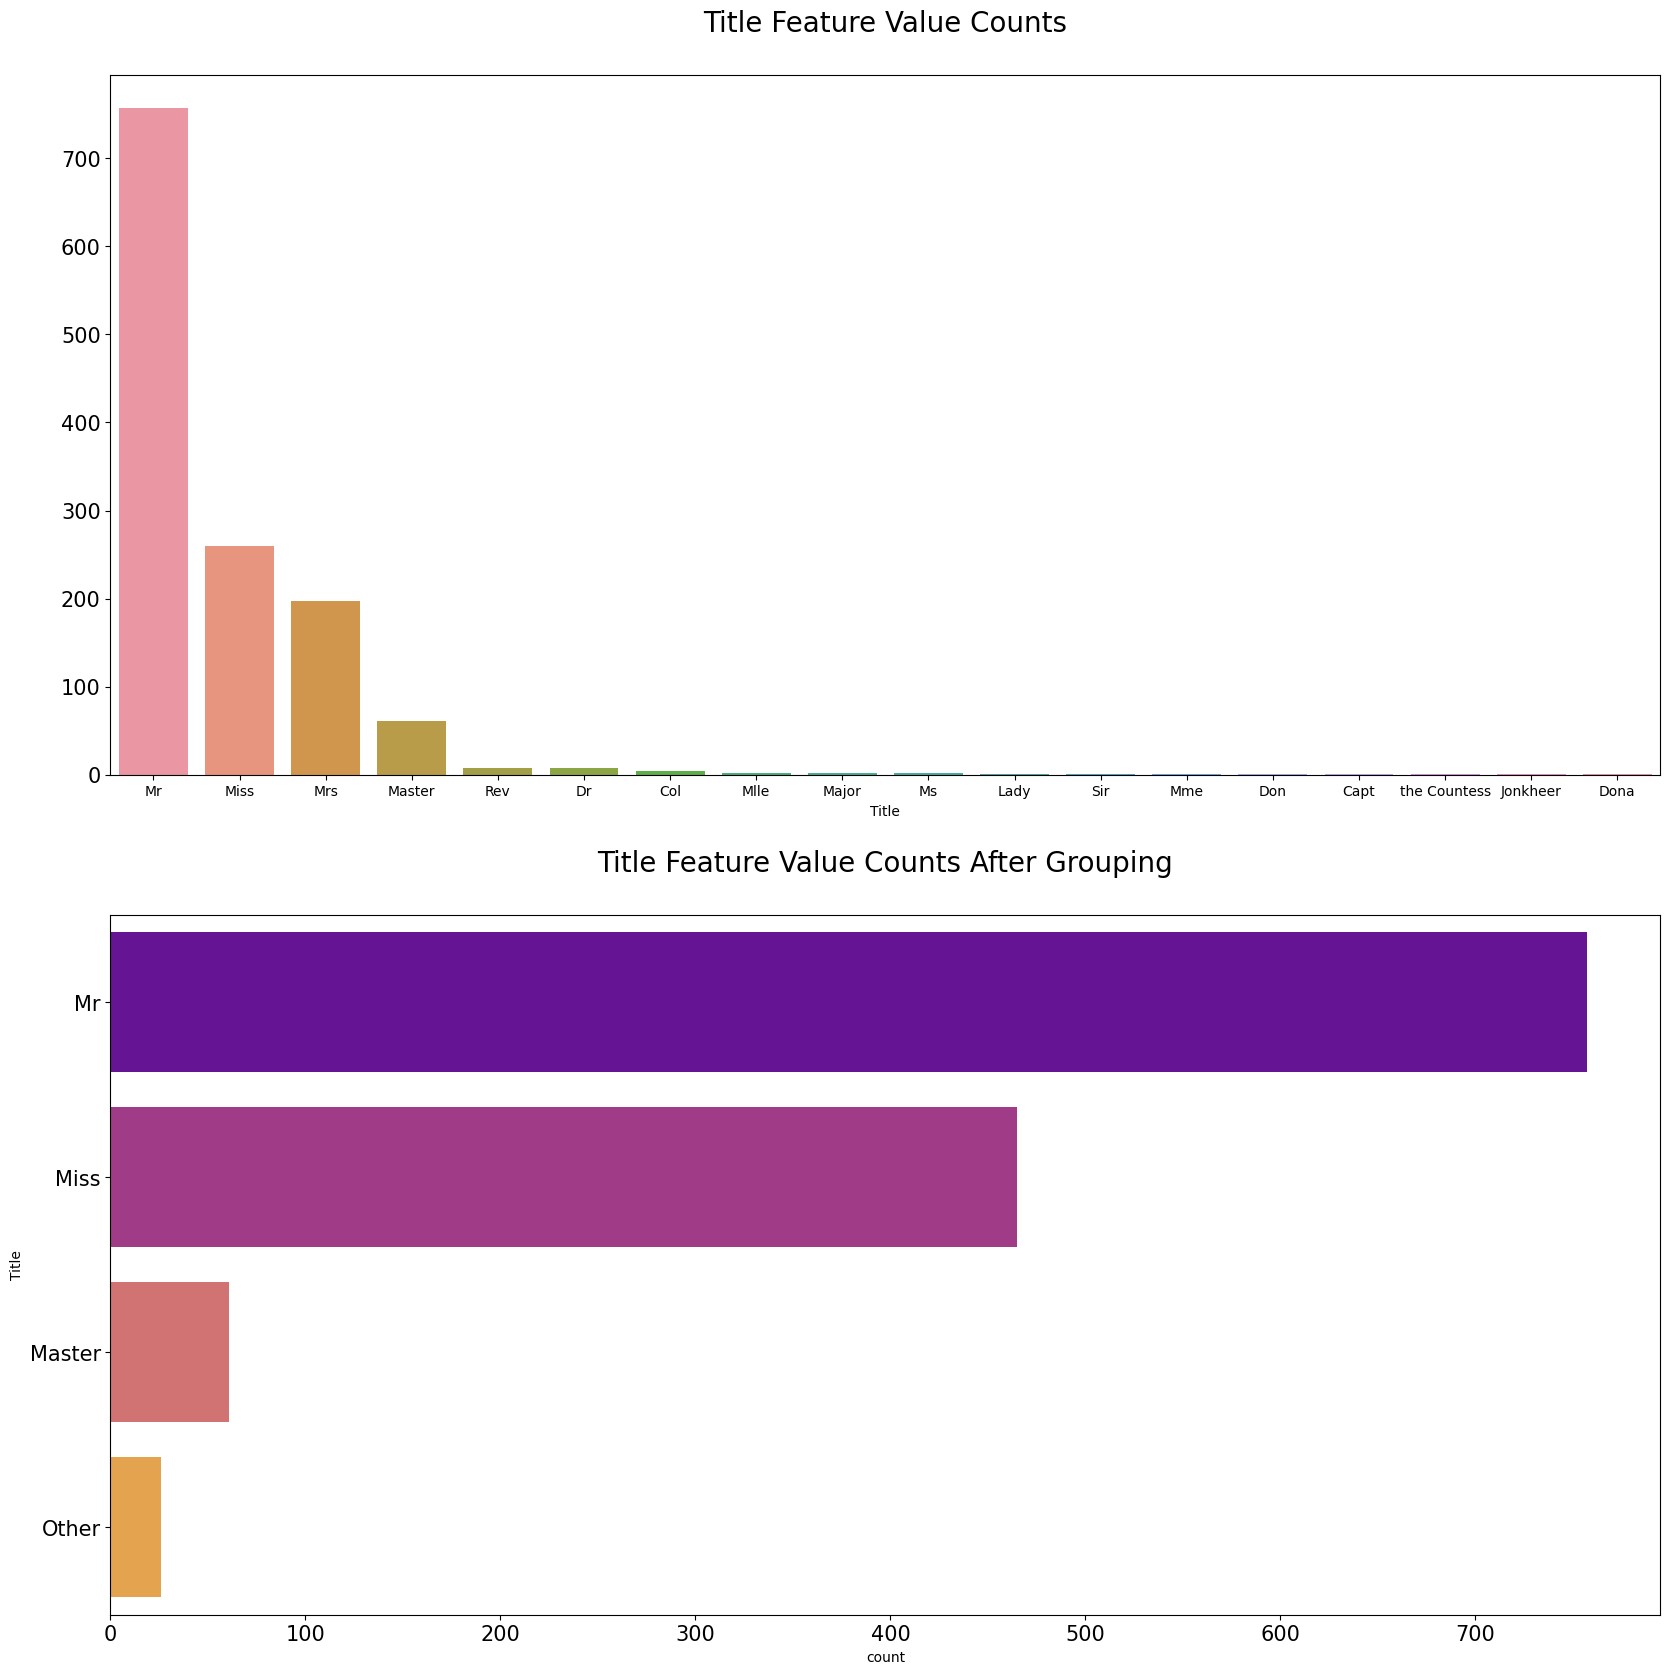

In [54]:
# Bining the Title and plotting the difference
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=all_data['Title'].value_counts().index, y=all_data['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

all_data['Title'] = all_data['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss')
all_data['Title'] = all_data['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Other')

# Count plot for the Title counts after grouping
sns.countplot(y=all_data['Title'], ax=axs[1], palette='plasma')
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

> *We can also extract the Family name from the name of each passenger. Thoes passengers who have a higher family have a high survival rate than others.*

In [55]:
# Extracting the family name

# Initialize an empty list to store family names
family_names = []

# Iterate through each row in the 'Name' column of the DataFrame
for i in range(len(all_data)):
    # Get the full name from the 'Name' column
    full_name = all_data['Name'].iloc[i]

    # Check if the name contains a '(' (indicating a maiden name)
    if '(' in full_name:
        no_maiden_name = full_name.split('(')[0]
    else:
        no_maiden_name = full_name

    # Extract the family name (surname) from the name
    family_name = no_maiden_name.split(',')[0]
    
    # Extract the title from the name (not currently used)
    title = no_maiden_name.split(',')[1].strip().split(' ')[0]

    # Remove any punctuation from the family name
    for c in string.punctuation:
        family_name = family_name.replace(c, '').strip()

    # Append the extracted family name to the list
    family_names.append(family_name)

# Assign the list of family names to the 'Family' column in the DataFrame
all_data['Family'] = family_names

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">7. Fare</span>** 💵

In [56]:
# Displaying the Min, Max, and Mean fare values
max_fare = all_data['Fare'].max()
min_fare = all_data['Fare'].min()
mean_fare = all_data['Fare'].mean()

# Updated print statements
print(f'Highest Fare: {max_fare:.2f}')
print(f'Lowest Fare: {min_fare:.2f}')
print(f'Average Fare: {mean_fare:.2f}')


Highest Fare: 512.33
Lowest Fare: 0.00
Average Fare: 33.28


<Axes: xlabel='Fare', ylabel='Count'>

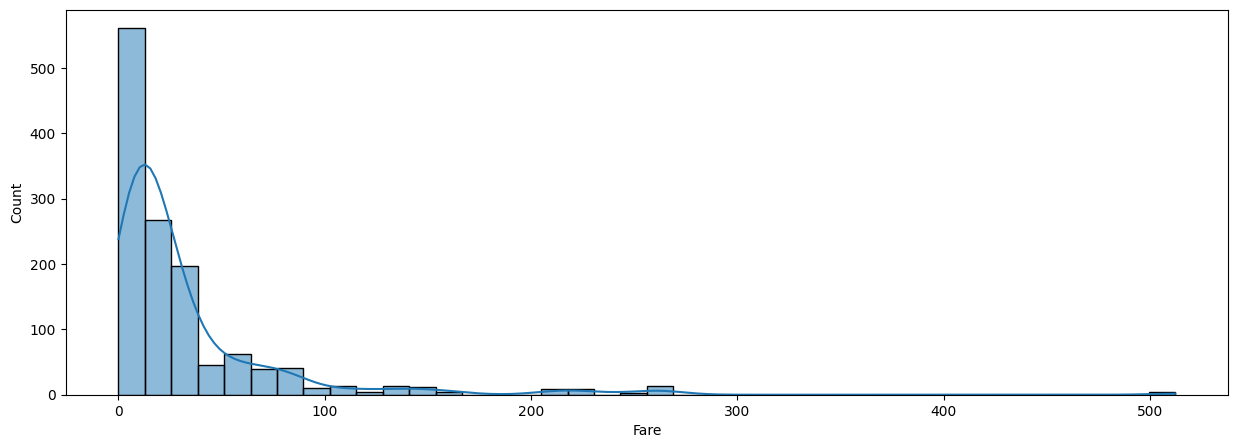

In [57]:
# Plot of Fare column
plt.figure(figsize=(15, 5))
sns.histplot(all_data['Fare'], bins=40, kde=True)

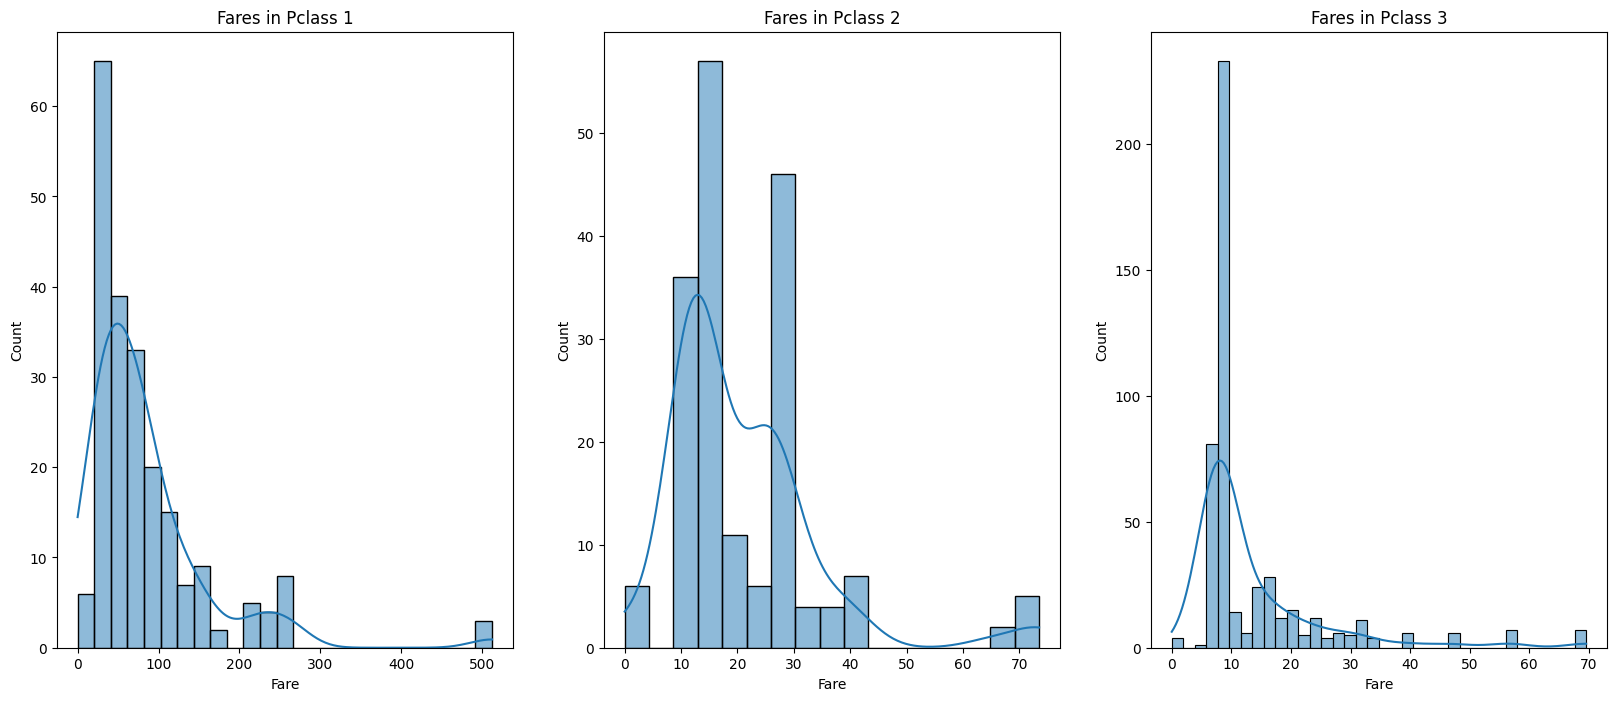

In [58]:
# Fare plot for each Pclasss
f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(train[train['Pclass'] == 1].Fare, ax=ax[0], kde=True)
ax[0].set_title('Fares in Pclass 1')

sns.histplot(train[train['Pclass'] == 2].Fare, ax=ax[1], kde=True)
ax[1].set_title('Fares in Pclass 2')

sns.histplot(train[train['Pclass'] == 3].Fare, ax=ax[2], kde=True)
ax[2].set_title('Fares in Pclass 3')

plt.show()

Log transform into proper gaussian distribution

<Axes: xlabel='Fare', ylabel='Count'>

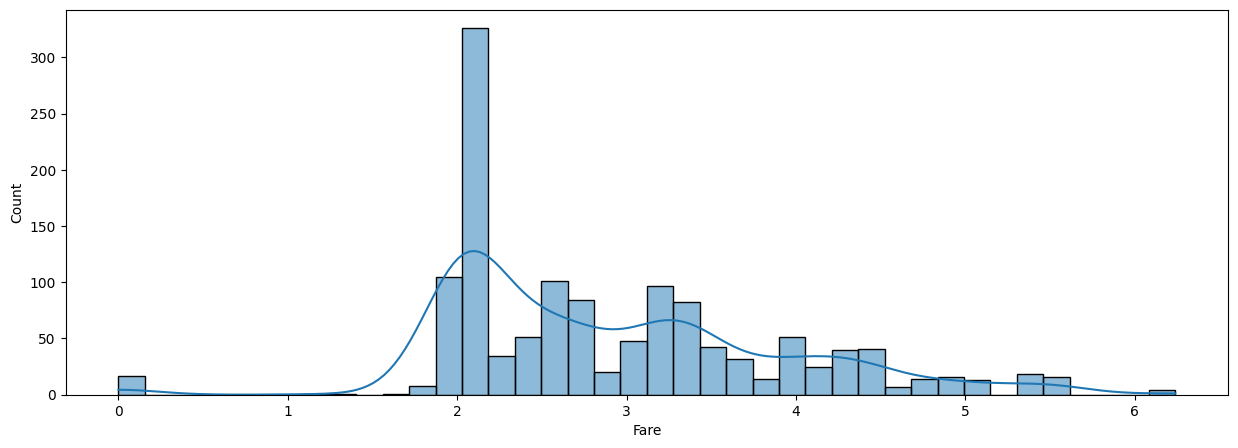

In [59]:
# To avoid overfitting changed to  gaussian distribution
train_fare = all_data['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
plt.figure(figsize=(15,5))
sns.histplot(train_fare,bins=40, kde=True)

# covert using this ??
# all_data['Fare']=all_data['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

Assuming zero values as a missing values
- Replacing zero values by the mean of each Pclass

In [60]:
# # replace the 0.0 values with mean fare by Pclass ??
# values = {'Fare': 0.0} 
# for df in all_data:
#     df.fillna(value=values,inplace=True)

# fare_table = (all_data.loc[all_data.Fare != 0.0][['Pclass','Fare']].groupby(['Pclass']).median()).copy()

# for df, fare_table in zip(all_data, fare_table):
#     for cls in np.unique(df.Pclass):
#         df.loc[((df.Fare == 0.0) & (df.Pclass == cls)), ['Fare']] = fare_table.loc[cls][0]

4 Categorical Bining

In [61]:
# # Convert Fate into 4 categorical data frame
# # Fare range

# all_data['Fare_bin']=0
# all_data.loc[all_data['Fare']<=7.91,'Fare_bin']=0
# all_data.loc[(all_data['Fare']>7.91)&(all_data['Fare']<=14.454),'Fare_bin']=1
# all_data.loc[(all_data['Fare']>14.454)&(all_data['Fare']<=31),'Fare_bin']=2
# all_data.loc[(all_data['Fare']>31)&(all_data['Fare']<=513),'Fare_bin']=3
# all_data['Fare_bin'].value_counts()

In [62]:
# # Drop Fare column
# all_data.drop(['Fare'], axis=1, inplace=True)
# all_data

13 Quantile Bining

In [63]:
# Bining into 13 quantiles
all_data['Fare'] = pd.qcut(all_data['Fare'], 13)
all_data['Fare'].value_counts()

Fare
(7.75, 7.896]        128
(-0.001, 7.25]       117
(23.25, 26.55]       109
(8.05, 10.5]         108
(34.075, 56.496]     104
(15.742, 23.25]      101
(83.475, 512.329]    100
(56.496, 83.475]      98
(7.25, 7.75]          93
(10.5, 13.0]          92
(26.55, 34.075]       91
(7.896, 8.05]         84
(13.0, 15.742]        84
Name: count, dtype: int64

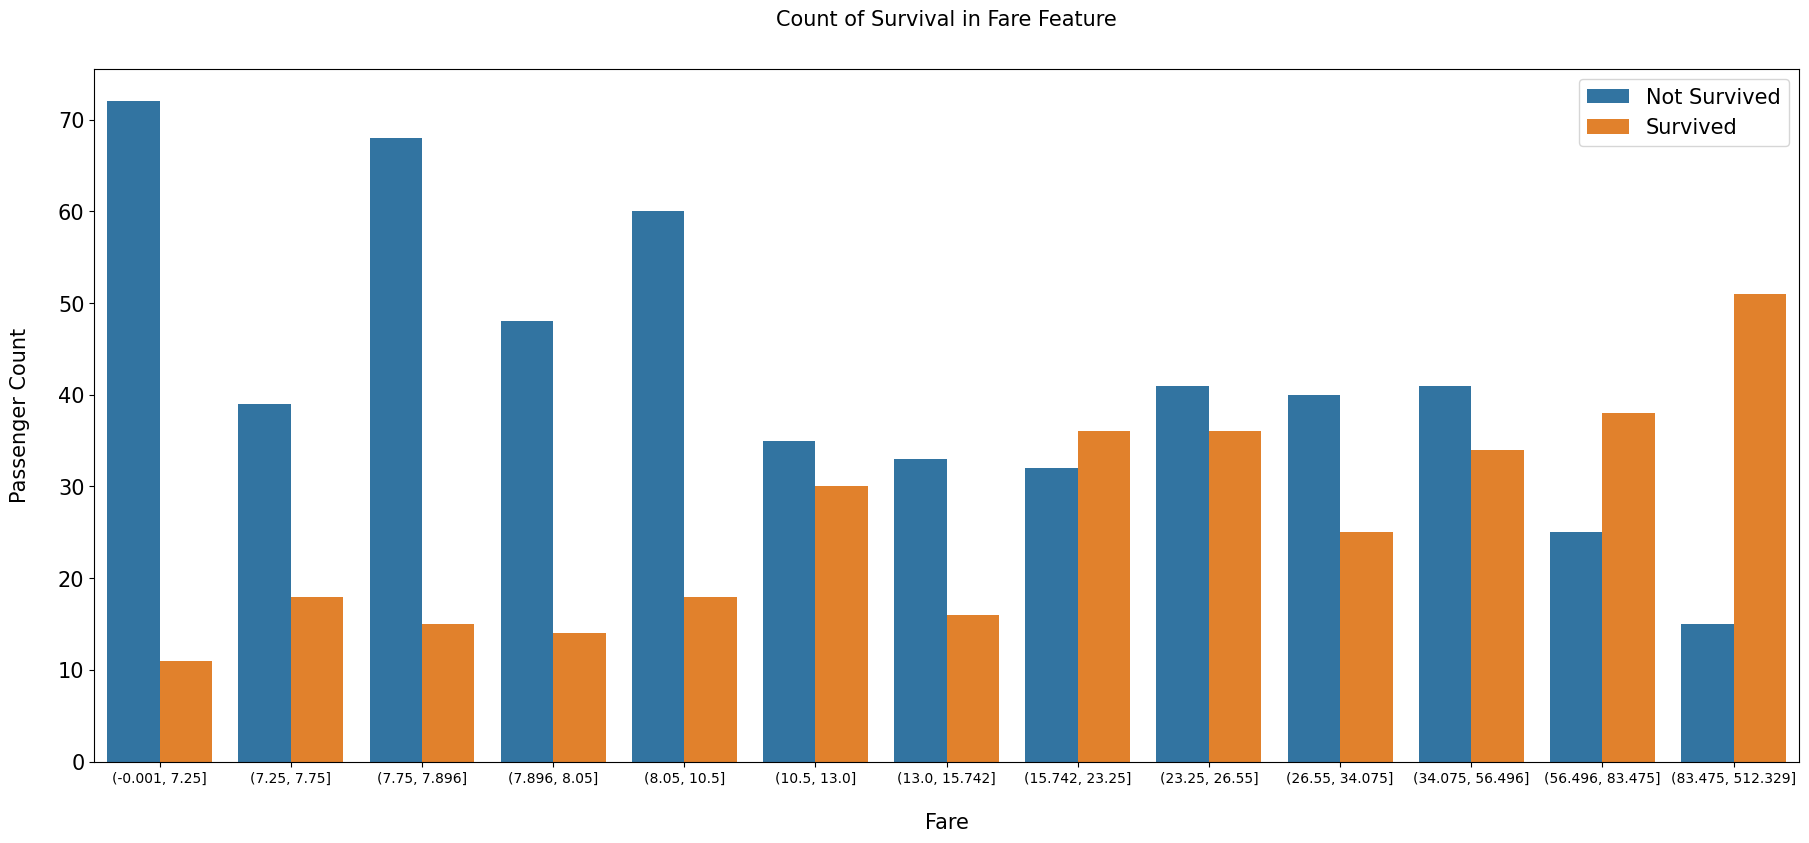

In [64]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=all_data)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

Text(0.5, 0.98, 'Survival by gender, age and rate')

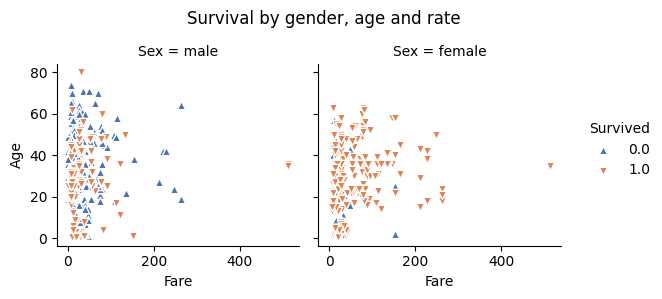

In [65]:
# Age vs Sex vs Fare
g = sns.FacetGrid(train, hue="Survived", col="Sex", margin_titles=True,
                palette="deep", hue_kws=dict(marker=["^", "v"]))

g.map(plt.scatter, "Fare", "Age", edgecolor="w").add_legend()

plt.subplots_adjust(top=0.8)

g.fig.suptitle('Survival by gender, age and rate')

### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">8. Age</span>** 👶👦🧔👴

In [66]:
# Displaying the Min, Max, and Mean Age values
max_age = all_data['Age'].max()
min_age = all_data['Age'].min()
mean_age = all_data['Age'].mean()

# Updated print statements with a different style
print(f"The oldest passenger was {max_age:.2f} years old.")
print(f"The youngest passenger was {min_age:.2f} years old.")
print(f"The average age on the ship was {mean_age:.2f} years.")


The oldest passenger was 80.00 years old.
The youngest passenger was 0.17 years old.
The average age on the ship was 29.26 years.


(10.0, 50.0)

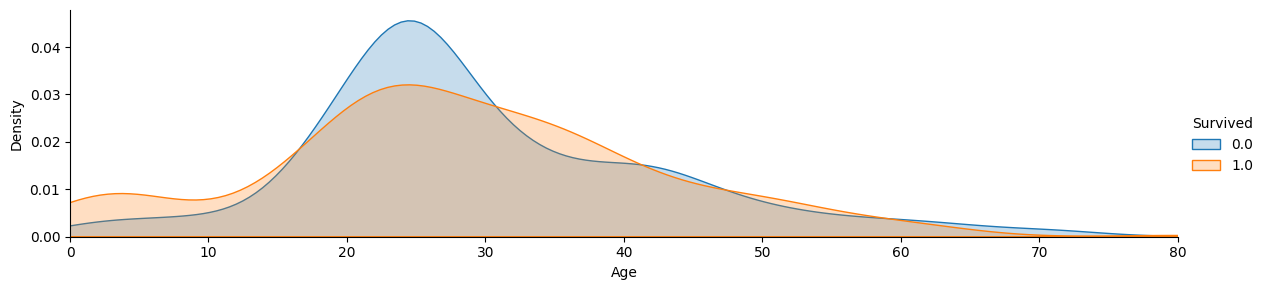

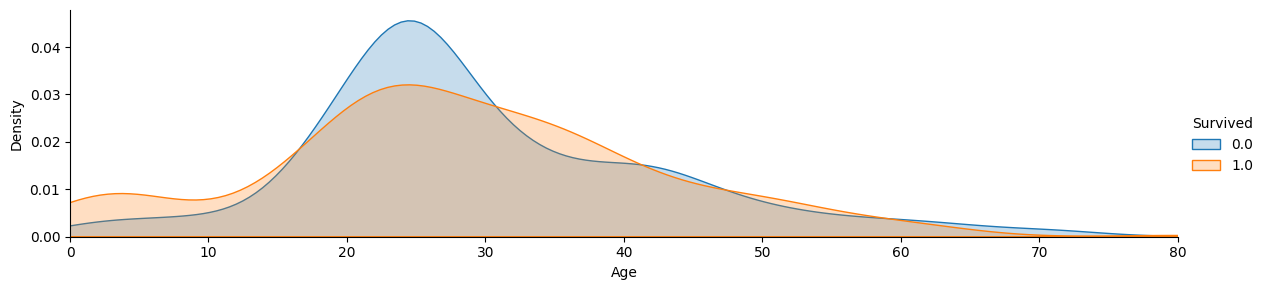

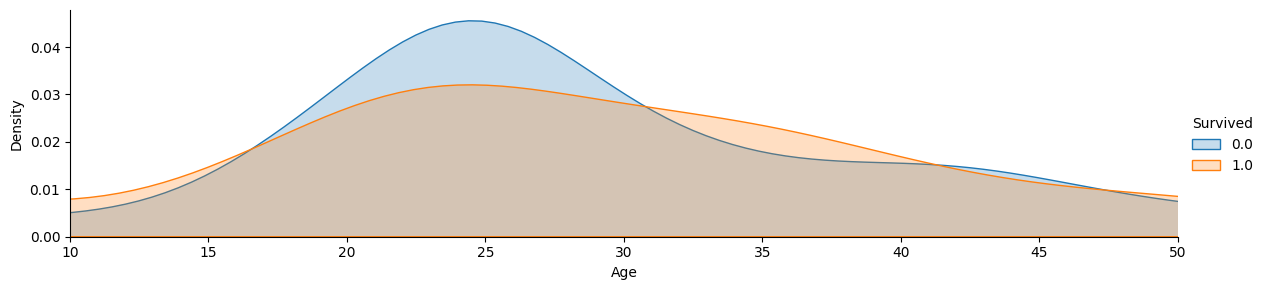

In [67]:
#vizualze the Age column for train, test and all_data 
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend() 

facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend() 

facet = sns.FacetGrid(all_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend() 
plt.xlim(10,50)

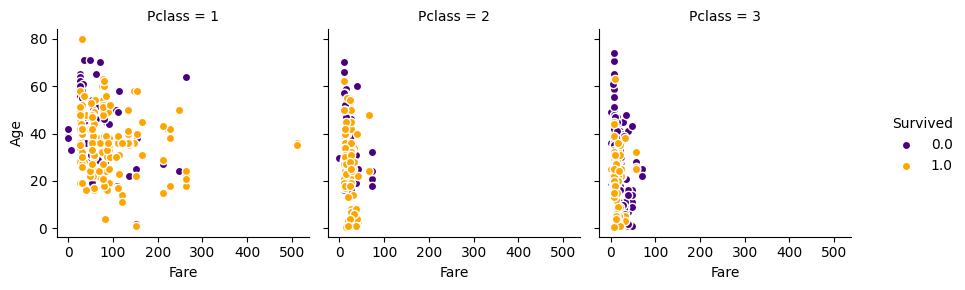

In [68]:
# Pclass vs Age vs Fare vs survival
g = sns.FacetGrid(train, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"Orange", 0:"Indigo"})
                  
g=g.map(plt.scatter, "Fare", "Age", edgecolor="w").add_legend()

Bining into 5 categories

In [69]:
#Binning age in categorical variable into 5 categories
# bin_edges = [0, 16, 32, 48, 64, 80]
# bin_labels = ['0-16', '17-32', '33-48', '49-64', '65-80']
# all_data['Age'] = pd.cut(all_data['Age'], bins=bin_edges, labels=bin_labels, include_lowest=True)
# all_data

In [70]:
# # better version 
# all_data['Age_bin']=0
# all_data.loc[all_data['Age']<=16,'Age']=0
# all_data.loc[(all_data['Age']>16)&(all_data['Age']<=32),'Age_bin']=1
# all_data.loc[(all_data['Age']>32)&(all_data['Age']<=48),'Age_bin']=2
# all_data.loc[(all_data['Age']>48)&(all_data['Age']<=64),'Age_bin']=3
# all_data.loc[all_data['Age']>64,'Age_bin']=4
# all_data.drop(['Age'], axis=1, inplace=True)
# all_data

10 Quantile Bining of Age

In [71]:
# Bining into 10 Q bins
all_data['Age'] = pd.qcut(all_data['Age'], 10)
all_data['Age'].value_counts()

Age
(22.0, 25.0]     254
(16.0, 21.0]     156
(40.0, 48.0]     136
(0.169, 16.0]    134
(34.0, 40.0]     131
(29.5, 34.0]     130
(48.0, 80.0]     119
(26.0, 29.5]     112
(21.0, 22.0]     107
(25.0, 26.0]      30
Name: count, dtype: int64

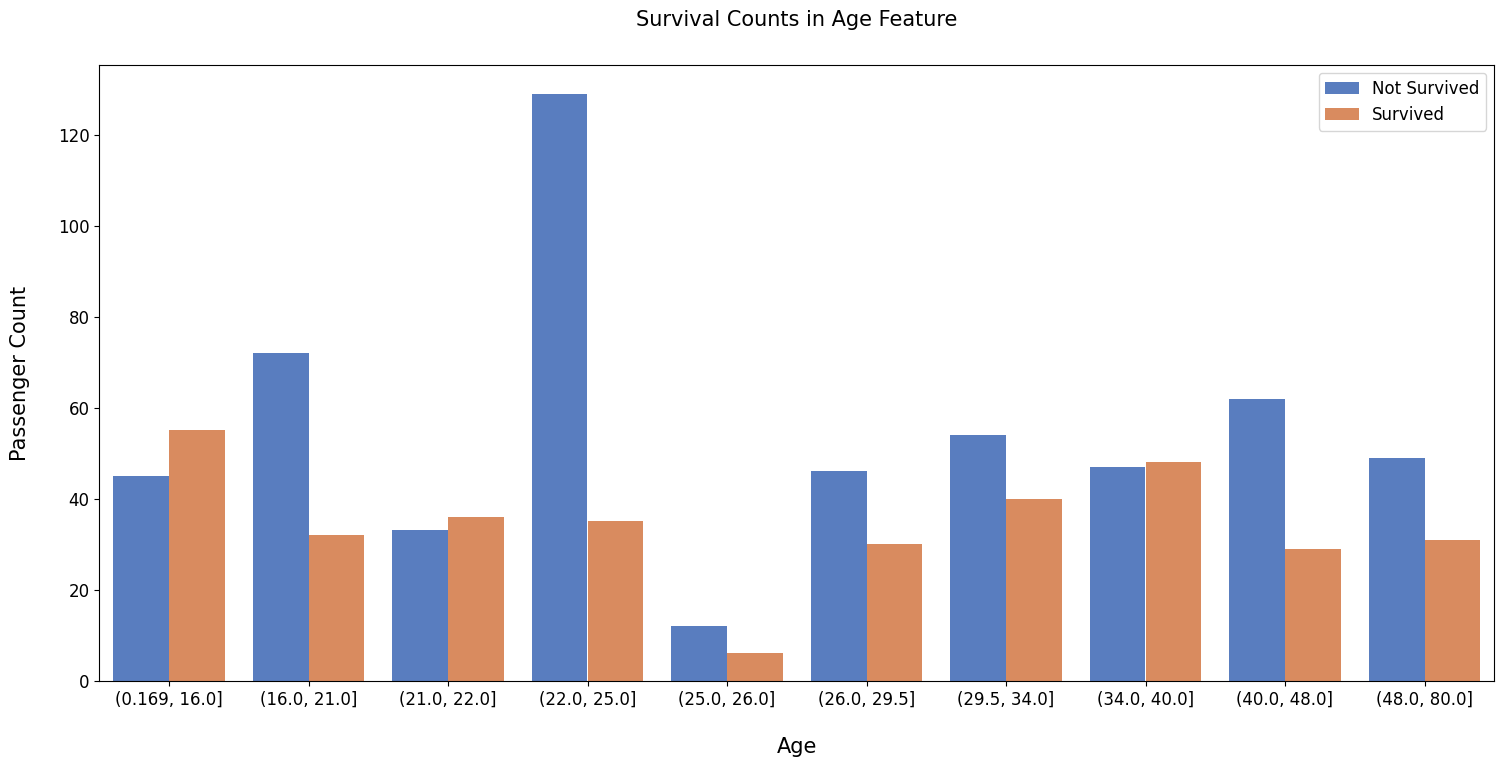

In [72]:
# Plotting for each bin in the Age columns with a count plot
fig, axs = plt.subplots(figsize=(18, 8))
sns.countplot(x='Age', hue='Survived', data=all_data, palette='muted')

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='both', labelsize=12)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 12})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()


### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">9. SibSp & Parch</span>** 👨‍👩‍👦🧬

In [73]:
# SibSp survival number and percentage
display(pd.crosstab([train.SibSp],train.Survived).style.background_gradient(cmap='plasma'))
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Survived,0.000000,1.000000
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [74]:
# Parch survival number and percentage
display(pd.crosstab(train.Parch,train.Survived).style.background_gradient(cmap='plasma'))
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Survived,0.000000,1.000000
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Taking SibSp and Parch as a one column Family?

In [75]:
# Maybe take SibSp and Parch together
# all_data.loc[:, 'Family'] = all_data["SibSp"] + all_data["Parch"]
# facet = sns.FacetGrid(all_data, hue="Survived",aspect=4)
# facet.map(sns.kdeplot,'Family',fill= True)
# facet.set(xlim=(0, all_data['Family'].max()))
# facet.add_legend()
# plt.xlim(0)

# all_data.drop('Parch', axis=1, inplace=True)
# all_data.drop('SibSp', axis=1, inplace=True)

Adding FamMembers and Alone Features

In [76]:
# # alone or not
# all_data['FamMembers']=0
# all_data['FamMembers']=all_data['Parch']+all_data['SibSp']#family size
# all_data['Alone']=0
# all_data.loc[all_data.FamMembers==0,'Alone']=1#Alone
# all_data[['Survived','SibSp','Parch','FamMembers', 'Alone']].head()

With family or not

In [77]:
# # Have family or not
# family_on_board = lambda row: 1 if (row['SibSp'] > 0 or row['Parch'] > 0) else 0
# all_data['Family'] = all_data.apply(family_on_board, axis=1)

# display(all_data[['Survived','SibSp','Parch','Family']].head())
# all_data[['Family', 'Survived']].groupby(['Family']).mean().sort_values(by='Survived', ascending=False)


In [78]:
# all_data.drop(['Parch', 'SibSp'], axis=1, inplace=True)

> *Extracting features like family size and groupng in 4 bins*

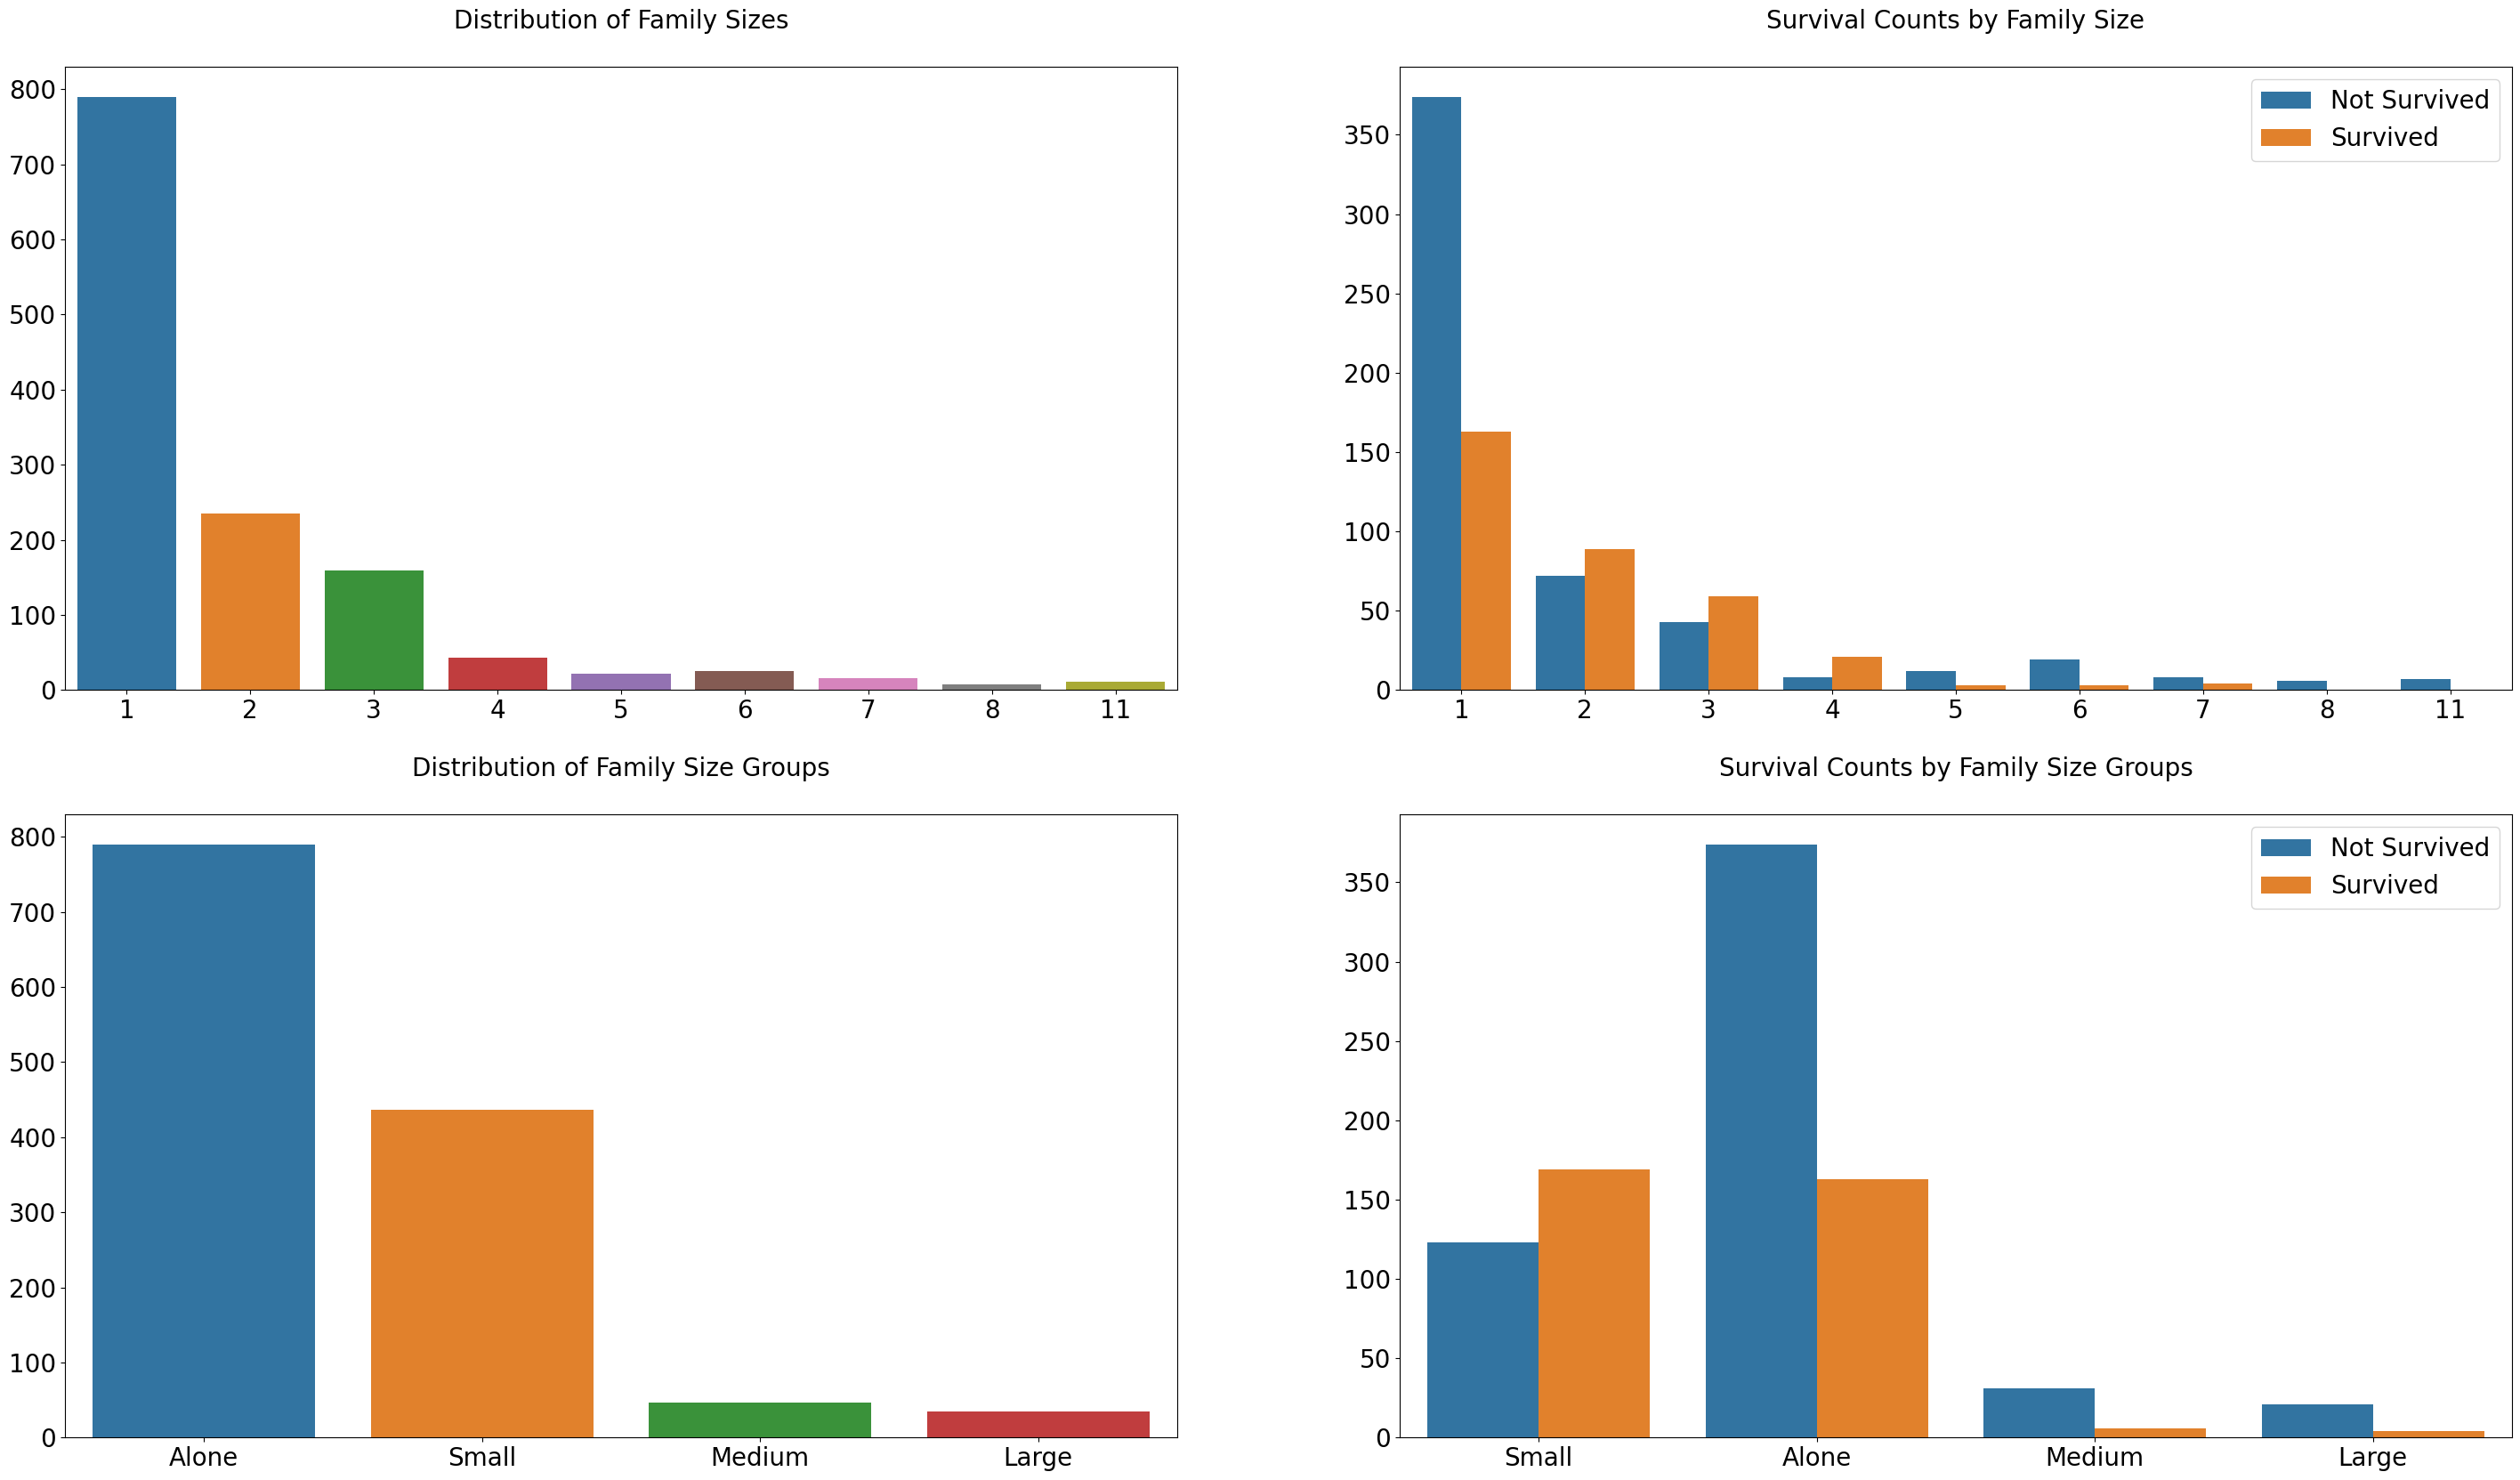

In [79]:
# Adding Family size feature
all_data['FamMembers'] = all_data['SibSp'] + all_data['Parch'] + 1

# Creating subplots
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

# Plotting Family Size Value Counts
sns.barplot(x=all_data['FamMembers'].value_counts().index, y=all_data['FamMembers'].value_counts().values, ax=axs[0][0])
sns.countplot(x='FamMembers', hue='Survived', data=all_data, ax=axs[0][1])

axs[0][0].set_title('Distribution of Family Sizes', size=20, y=1.05)
axs[0][1].set_title('Survival Counts by Family Size', size=20, y=1.05)

# Binning into 4 groups
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
all_data['FamMembers_Grouped'] = all_data['FamMembers'].map(family_map)

# Plotting Distribution of Family Size Groups
sns.barplot(x=all_data['FamMembers_Grouped'].value_counts().index, y=all_data['FamMembers_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='FamMembers_Grouped', hue='Survived', data=all_data, ax=axs[1][1])

axs[1][0].set_title('Distribution of Family Size Groups', size=20, y=1.05)
axs[1][1].set_title('Survival Counts by Family Size Groups', size=20, y=1.05)

# Setting legends and formatting
for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()


### **<span style="background: linear-gradient(to right, #e74c3c, #3498db); -webkit-background-clip: text; color: transparent;">10. Ticket</span>** 🎫

In [80]:
# Ticket have repeated values which most likely means those passenger were together
all_data['Ticket'].value_counts()

Ticket
CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: count, Length: 929, dtype: int64

Grouping them based on same ticket num

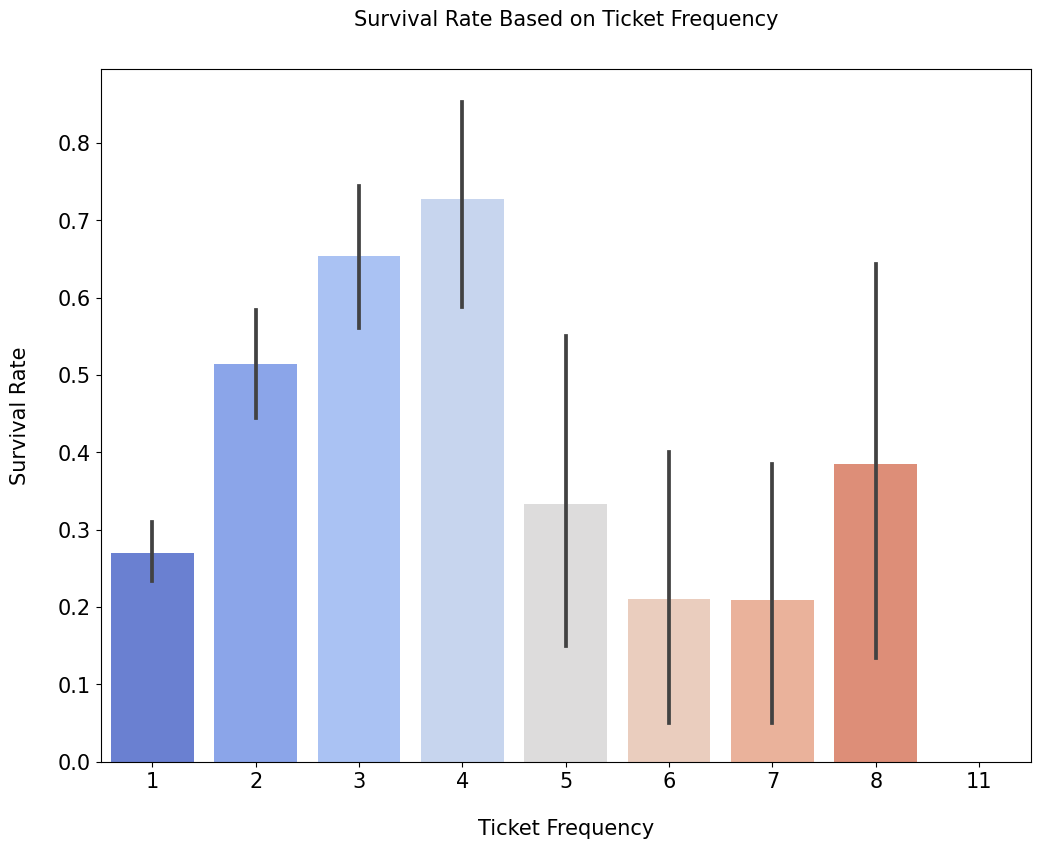

In [81]:
# Adding new Ticket frequecy feature
all_data['TicketCount'] = all_data.groupby('Ticket')['Ticket'].transform('count')

# Plotting survival based on Ticket frequency with a bar plot
fig, axs = plt.subplots(figsize=(12, 9))
sns.barplot(x='TicketCount', y='Survived', data=all_data, palette='coolwarm')

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Survival Rate', size=15, labelpad=20)
plt.tick_params(axis='both', labelsize=15)

plt.title('Survival Rate Based on Ticket Frequency', size=15, y=1.05)

plt.show()


In [82]:
# # To drop ticket
# all_data.drop('Ticket', axis=1, inplace=True)

#### **More Complex feature extraction**

In [83]:
# Splitting the data into train and test sets
train, test = all_data.loc[:890], all_data.loc[891:]
dfs = [train, test]

# Finding duplicate family names and tickets in the training and test sets
dupFamList = [x for x in train['Family'].unique() if x in test['Family'].unique()]
dupTickets = [x for x in train['Ticket'].unique() if x in test['Ticket'].unique()]

# Grouping by 'Family' and 'Ticket' and calculating median values for survival rates
fam_surv_rate = train.groupby('Family')[['Survived', 'FamMembers']].median().reset_index()
tkt_surv_rate = train.groupby('Ticket')[['Survived', 'TicketCount']].median().reset_index()

# Dictionary to store family and ticket survival rates
fam_rates = {}
tkt_rates = {}

# Iterating over family survival rates
for i in range(len(fam_surv_rate)):
    # Checking if a family exists in both training and test sets and has more than one member
    if fam_surv_rate.loc[i, 'Family'] in dupFamList and fam_surv_rate.loc[i, 'FamMembers'] > 1:
        fam_rates[fam_surv_rate.loc[i, 'Family']] = fam_surv_rate.loc[i, 'Survived']

# Iterating over ticket survival rates
for i in range(len(tkt_surv_rate)):
    # Checking if a ticket exists in both training and test sets and has more than one member
    if tkt_surv_rate.loc[i, 'Ticket'] in dupTickets and tkt_surv_rate.loc[i, 'TicketCount'] > 1:
        tkt_rates[tkt_surv_rate.loc[i, 'Ticket']] = tkt_surv_rate.loc[i, 'Survived']


In [84]:
# Calculate mean survival rate for the training set
mean_surv = np.mean(train['Survived'])

# Lists to store family survival rates and flags for missing values
fam_surv_train, fam_surv_train_NA = [], []
fam_surv_test, fam_surv_test_NA = [], []

# Calculate family survival rates and missing value flags for the training set
for i in range(len(train)):
    if train['Family'][i] in fam_rates:
        fam_surv_train.append(fam_rates[train['Family'][i]])
        fam_surv_train_NA.append(1)
    else:
        fam_surv_train.append(mean_surv)
        fam_surv_train_NA.append(0)

# Calculate family survival rates and missing value flags for the test set
for i in range(len(test)):
    if test['Family'].iloc[i] in fam_rates:
        fam_surv_test.append(fam_rates[test['Family'].iloc[i]])
        fam_surv_test_NA.append(1)
    else:
        fam_surv_test.append(mean_surv)
        fam_surv_test_NA.append(0)

# Assign family survival rates and missing value flags to the train and test sets
train['Family_rate'] = fam_surv_train
train['Family_rate_NA'] = fam_surv_train_NA
test['Family_rate'] = fam_surv_test
test['Family_rate_NA'] = fam_surv_test_NA

# Lists to store ticket survival rates and flags for missing values
train_Ticket_rate, train_Ticket_rate_NA = [], []
test_Ticket_rate, test_Ticket_rate_NA = [], []

# Calculate ticket survival rates and missing value flags for the training set
for i in range(len(train)):
    if train['Ticket'][i] in tkt_rates:
        train_Ticket_rate.append(tkt_rates[train['Ticket'][i]])
        train_Ticket_rate_NA.append(1)
    else:
        train_Ticket_rate.append(mean_surv)
        train_Ticket_rate_NA.append(0)

# Calculate ticket survival rates and missing value flags for the test set
for i in range(len(test)):
    if test['Ticket'].iloc[i] in tkt_rates:
        test_Ticket_rate.append(tkt_rates[test['Ticket'].iloc[i]])
        test_Ticket_rate_NA.append(1)
    else:
        test_Ticket_rate.append(mean_surv)
        test_Ticket_rate_NA.append(0)

# Assign ticket survival rates and missing value flags to the train and test sets
train['Ticket_rate'] = train_Ticket_rate
train['Ticket_rate_NA'] = train_Ticket_rate_NA
test['Ticket_rate'] = test_Ticket_rate
test['Ticket_rate_NA'] = test_Ticket_rate_NA

# Calculate overall survival rates and missing value flags for both train and test sets
for df in [train, test]:
    df['Survival_Rate'] = (df['Ticket_rate'] + df['Family_rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_rate_NA'] + df['Family_rate_NA']) / 2

---

<style>
  .custom-box {
    background: linear-gradient(145deg, #3498db, #1abc9c); /* Updated gradient colors */
    padding: 15px;border-radius: 8px;margin: 20px; max-width: 300px;
    text-align: center;height: 70px;display: flex;flex-direction: column;
    justify-content: center; align-items: center; transition: background-color 0.3s ease-in-out;
  }
  .custom-box:hover {
    background: linear-gradient(145deg, #2ecc71, #3498db);
  }
  .custom-box h2 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 32px; margin: -5px 0 0 0;
  }
</style>
<div class="custom-box">
    <h2>
        👾 <strong>Encoding</strong> 🛸
    </h2>
</div>

In [85]:
# Label encoding
continuous_attributes = ['Embarked', 'Sex', 'Cabin', 'Title', 'FamMembers_Grouped', 'Age', 'Fare']

# Apply LabelEncoder to continuous attributes for both train and test sets
for dataset in dfs:
    dataset[continuous_attributes] = dataset[continuous_attributes].apply(LabelEncoder().fit_transform)

# One-hot encoding
categorical_attributes = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'FamMembers_Grouped']
encoded_features = []

# Apply OneHotEncoder and concatenate the resulting DataFrames for both train and test sets
for dataset in dfs:
    encoded_features.extend([
        pd.get_dummies(dataset[attribute], prefix=attribute) for attribute in categorical_attributes
    ])

# Concatenate the encoded features to the original DataFrames
train = pd.concat([train, *encoded_features[:6]], axis=1)
test = pd.concat([test, *encoded_features[6:]], axis=1)

# Concatenate train and test sets
all_data = pd.concat([train, test], sort=True).reset_index(drop=True)

# Columns to drop
columns_to_drop = [
    'Cabin', 'Embarked', 'Family', 'FamMembers', 'FamMembers_Grouped', 'Survived',
    'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
    'Ticket_rate', 'Family_rate', 'Ticket_rate_NA', 'Family_rate_NA'
]

# Drop specified columns
all_data.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows of the processed data
all_data.head()


,Age,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Embarked_0,Embarked_1,Embarked_2,FamMembers_Grouped_0,FamMembers_Grouped_1,...,Pclass_3,Sex_0,Sex_1,Survival_Rate,Survival_Rate_NA,TicketCount,Title_0,Title_1,Title_2,Title_3
0,2,False,False,False,True,False,False,True,False,False,...,True,False,True,0.383838,0.0,1,False,False,True,False
1,7,True,False,False,False,True,False,False,False,False,...,False,True,False,1.000000,1.0,2,False,True,False,False
2,4,False,False,False,True,False,False,True,True,False,...,True,True,False,0.383838,0.0,1,False,True,False,False
3,7,True,False,False,False,False,False,True,False,False,...,False,True,False,0.383838,0.0,2,False,True,False,False
4,7,False,False,False,True,False,False,True,True,False,...,True,False,True,0.383838,0.0,1,False,False,True,False


> *There are about 26 features now, which is a big improvment from the 10 features (excluding passengerID and Survived) before.*

---

Final Viz

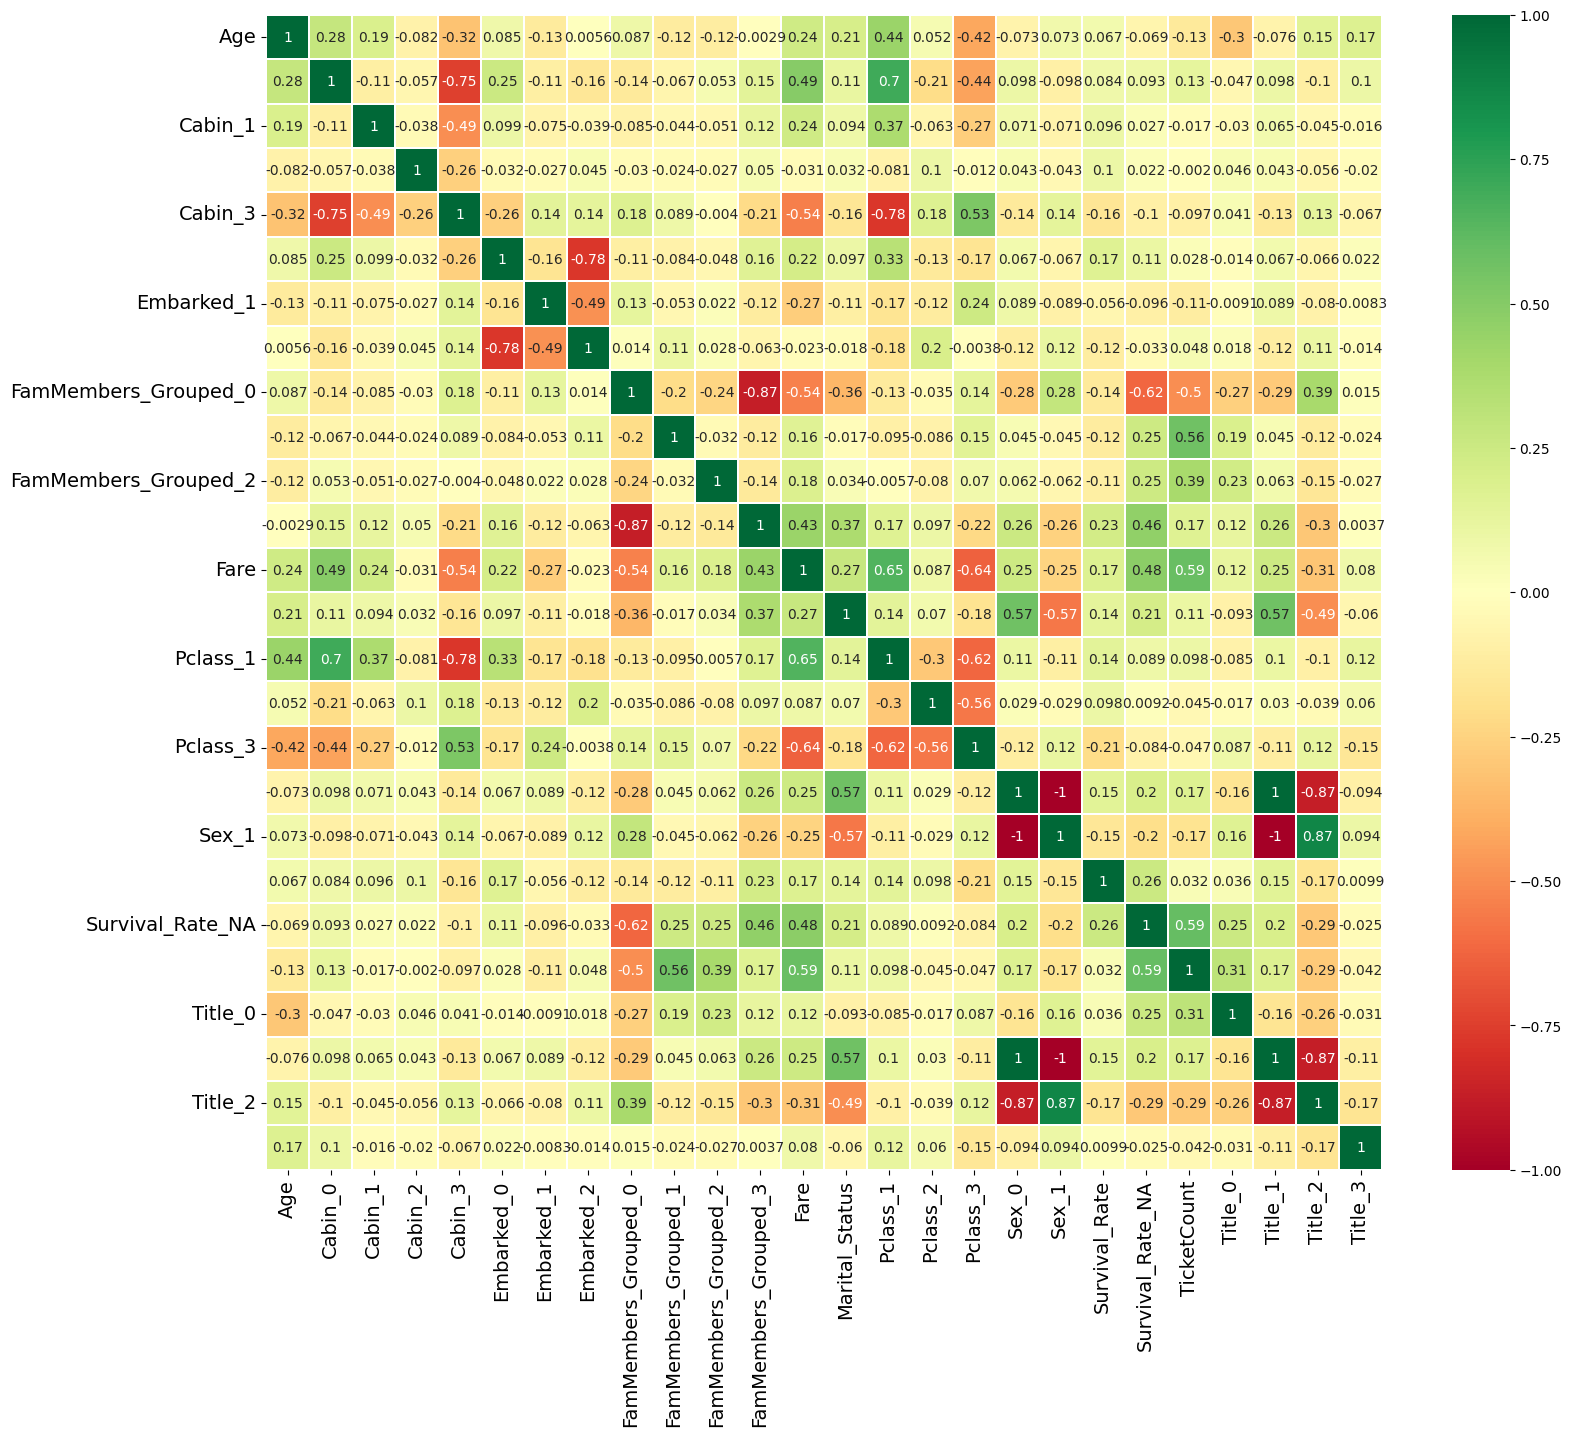

In [86]:
# Final data correlation plot
sns.heatmap(all_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [87]:
# The total extracted features 
train.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title',
       'Marital_Status', 'Family', 'FamMembers', 'FamMembers_Grouped',
       'TicketCount', 'Family_rate', 'Family_rate_NA', 'Ticket_rate',
       'Ticket_rate_NA', 'Survival_Rate', 'Survival_Rate_NA', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1', 'Cabin_0', 'Cabin_1',
       'Cabin_2', 'Cabin_3', 'Embarked_0', 'Embarked_1', 'Embarked_2',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'FamMembers_Grouped_0',
       'FamMembers_Grouped_1', 'FamMembers_Grouped_2', 'FamMembers_Grouped_3'],
      dtype='object')

In [88]:
# Split all_data back into train and test
# train, test = all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [89]:
# sns.heatmap(train.corr(),annot=True,cmap='YlOrRd',linewidths=0.2,annot_kws={'size':10})
# fig=plt.gcf()
# fig.set_size_inches(18,15)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

---

<style>
  .custom-box {
    background: linear-gradient(145deg, #3498db, #1abc9c); /* Updated gradient colors */
    padding: 15px;border-radius: 8px;margin: 20px; max-width: 350px;
    text-align: center;height: 70px;display: flex;flex-direction: column;
    justify-content: center; align-items: center; transition: background-color 0.3s ease-in-out;
  }
  .custom-box:hover {
    background: linear-gradient(145deg, #2ecc71, #3498db);
  }
  .custom-box h2 {
    color: #ecf0f1; font-family: 'Arial', sans-serif;
    font-size: 32px; margin: -5px 0 0 0;
  }
</style>
<div class="custom-box">
    <h2>
        🤖 <strong>The Model</strong> 🎲
    </h2>
</div>

In [90]:
# Transforming the training data
train_X = StandardScaler().fit_transform(train.drop(columns=columns_to_drop))
train_Y = train['Survived'].values

# Transforming the test data
test_X = StandardScaler().fit_transform(test.drop(columns=columns_to_drop))

# Displaying shapes of the transformed data
print('\nTraining Data Transformation:')
print('   - Features shape after scaling: {}'.format(train_X.shape))
print('   - Labels shape: {}'.format(train_Y.shape))

print('\nTest Data Transformation:')
print('   - Features shape after scaling: {}'.format(test_X.shape))




Training Data Transformation:
   - Features shape after scaling: (891, 26)
   - Labels shape: (891,)

Test Data Transformation:
   - Features shape after scaling: (418, 26)


### `Random Forest classifier using a Stratified K-fold`

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score

# Defining the best model
best_model = RandomForestClassifier(criterion='gini', n_estimators=1000, max_depth=5, min_samples_split=10,
                                     min_samples_leaf=1, oob_score=True,
                                     random_state=42, n_jobs=-1,
                                     verbose=1) 

# Number of folds
n_folds = 5
accuracy_avg = 0
max_accuracy = 0  # Variable to store maximum accuracy

# DataFrames to store probabilities and feature weights
probs = pd.DataFrame(np.zeros((len(test_X), n_folds * 2)), columns=[f'Fold_{i}_Prob_{j}' for i in range(1, n_folds + 1) for j in range(2)])
feat_weights = pd.DataFrame(np.zeros((train_X.shape[1], n_folds)), columns=[f'Fold_{i}' for i in range(1, n_folds + 1)], index=all_data.columns)
fprs, tprs, scores = [], [], []

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=n_folds, random_state=n_folds, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_X, train_Y), 1):
    print(f'\nFold {fold}:\n')
    
    # Fitting the model
    best_model.fit(train_X[trn_idx], train_Y[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(train_Y[trn_idx], best_model.predict_proba(train_X[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(train_Y[val_idx], best_model.predict_proba(train_X[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
    
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # Storing test_X probabilities
    probs.loc[:, f'Fold_{fold}_Prob_0'] = best_model.predict_proba(test_X)[:, 0]
    probs.loc[:, f'Fold_{fold}_Prob_1'] = best_model.predict_proba(test_X)[:, 1]
    
    # Storing feature weights
    feat_weights.iloc[:, fold - 1] = best_model.feature_importances_
    
    # Computing accuracy score
    train_pred = best_model.predict(train_X[val_idx])
    accuracy = accuracy_score(train_Y[val_idx], train_pred)
    accuracy_avg += accuracy
    
    print(f'Fold {fold} Accuracy Score: {accuracy}\n')
    
    # Update maximum accuracy
    if accuracy > max_accuracy:
        max_accuracy = accuracy

print(f'Average Accuracy Score: {accuracy_avg / n_folds}')
print(f'Maximum Accuracy Score: {max_accuracy}')



Fold 1:



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Fold 1 Accuracy Score: 0.7988826815642458


Fold 2:



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Fold 2 Accuracy Score: 0.848314606741573


Fold 3:



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Fold 3 Accuracy Score: 0.8089887640449438


Fold 4:



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


Fold 4 Accuracy Score: 0.8820224719101124


Fold 5:



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s


Fold 5 Accuracy Score: 0.8820224719101124

Average Accuracy Score: 0.8440461992341974
Maximum Accuracy Score: 0.8820224719101124


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


### `Grid Search`

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring='accuracy', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(train_X, train_Y)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# test_pred = best_model.predict(test_X)
# test_accuracy = accuracy_score(test_Y, test_pred)
# print("Test Accuracy with Best Model: ", test_accuracy


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Best Accuracy:  0.8518109346557028


### `Ensemble Learning`

In [93]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Assuming train_X, train_Y, test_X, and test_Y are already defined

# Define individual models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
logistic_model = LogisticRegression(random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Create an ensemble using VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('logistic_regression', logistic_model),
    ('support_vector_machine', svm_model)
], voting='soft')  # 'soft' for soft voting (using predicted probabilities)

# Evaluate individual models
models = [('Random Forest', rf_model), ('Logistic Regression', logistic_model), ('SVM', svm_model), ('Ensemble', ensemble)]

for name, model in models:
    cv_scores = cross_val_score(model, train_X, train_Y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print(f'{name} - Mean Cross-Validation Accuracy: {cv_scores.mean():.4f} (Std: {cv_scores.std():.4f})')

# # Train and evaluate the ensemble
# ensemble.fit(train_X, train_Y)
# ensemble_predictions = ensemble.predict(test_X)
# ensemble_accuracy = accuracy_score(test_Y, ensemble_predictions)

# print(f'\nEnsemble Accuracy on Test Set: {ensemble_accuracy:.4f}')


Random Forest - Mean Cross-Validation Accuracy: 0.8462 (Std: 0.0221)
Logistic Regression - Mean Cross-Validation Accuracy: 0.8518 (Std: 0.0365)
SVM - Mean Cross-Validation Accuracy: 0.8440 (Std: 0.0200)
Ensemble - Mean Cross-Validation Accuracy: 0.8462 (Std: 0.0234)


#### `Feature weights` 
- we can see the feature we add have a huge improvement on the model accuracy

<Figure size 1500x1000 with 0 Axes>

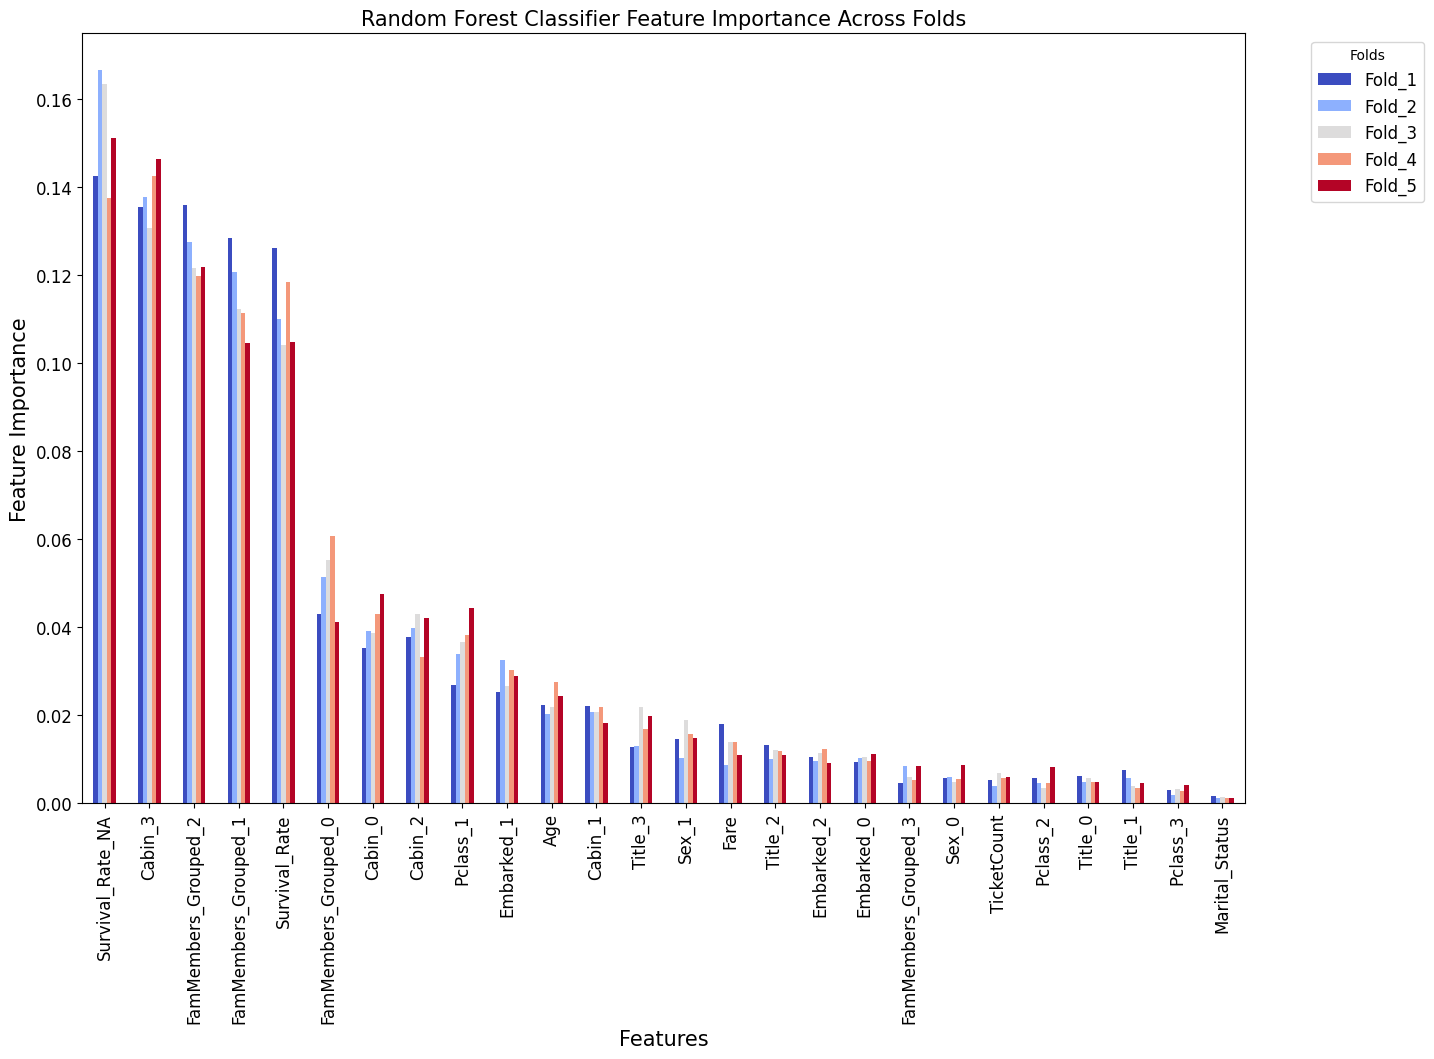

In [94]:
# Calculate mean feature weights
feat_weights['Mean_Importance'] = feat_weights.mean(axis=1)

# Sort features by mean importance in descending order
feat_weights.sort_values(by='Mean_Importance', inplace=True, ascending=False)

# Plotting
plt.figure(figsize=(15, 10))

# Grouped bar plot for feature importances across folds
ax = feat_weights.iloc[:, :-1].plot(kind='bar', colormap='coolwarm', figsize=(15, 10))

# Customizing the plot
ax.set_xlabel('Features', fontsize=15)  # X-axis label
ax.set_ylabel('Feature Importance', fontsize=15)  # Y-axis label
ax.tick_params(axis='both', labelsize=12)  # Tick label size
ax.set_title('Random Forest Classifier Feature Importance Across Folds', fontsize=15)  # Plot title
ax.legend(title='Folds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Legend

# Display the plot
plt.show()


In [95]:
# # ROC curve plot
# def plot_roc_curve(fprs, tprs):
    
#     tprs_interp = []
#     aucs = []
#     mean_fpr = np.linspace(0, 1, 100)
#     f, ax = plt.subplots(figsize=(15, 15))
    
#     # Plotting ROC for each fold and computing AUC scores
#     for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
#         tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
#         tprs_interp[-1][0] = 0.0
#         roc_auc = auc(fpr, tpr)
#         aucs.append(roc_auc)
#         ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
#     # Plotting ROC for random guessing
#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
#     mean_tpr = np.mean(tprs_interp, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
    
#     # Plotting the mean ROC
#     ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
#     # Plotting the standard deviation around the mean ROC Curve
#     std_tpr = np.std(tprs_interp, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
#     ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
#     ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
#     ax.tick_params(axis='x', labelsize=15)
#     ax.tick_params(axis='y', labelsize=15)
#     ax.set_xlim([-0.05, 1.05])
#     ax.set_ylim([-0.05, 1.05])

#     ax.set_title('ROC Curves of Folds', size=20, y=1.02)
#     ax.legend(loc='lower right', prop={'size': 13})
    
#     plt.show()

# plot_roc_curve(fprs, tprs)

In [96]:
# Extract columns related to class 1 probabilities
class_survived_cols = [col for col in probs.columns if col.endswith('Prob_1')]

# Calculate the average probability of class 1 across folds
probs['1'] = probs[class_survived_cols].sum(axis=1) / n_folds

# Calculate the average probability of class 0 across folds
probs['0'] = probs.drop(columns=class_survived_cols).sum(axis=1) / n_folds

# Initialize 'pred' column with 0
probs['pred'] = 0

# Assign class 1 prediction for samples with probability >= 0.5
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

# Convert 'pred' column to integer for final predictions
y_pred = probs['pred'].astype(int)

# Create a DataFrame for submission
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test['PassengerId']
submission_df['Survived'] = y_pred.values

# Save predictions to a CSV file
submission_df.to_csv('Final_sumbmission.csv', header=True, index=False)

# Display the first 10 rows of the submission DataFrame
submission_df.head(10)


,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


---

Thank You!!